<a href="https://colab.research.google.com/github/Yuanranzhu/SINN/blob/main/FPU_chain_SINN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!hostname

gnode014.cluster


In [2]:
!nvidia-smi

Fri Mar 22 19:05:08 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA H100 PCIe               Off | 00000000:A8:00.0 Off |                    0 |
| N/A   32C    P0              77W / 350W |   7253MiB / 81559MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [3]:
import itertools as it
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import torch.fft
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sdeint
from toolbox import (
    make_loss,
    StatLoss,
    SINN,
    FPU
)
import time

In [4]:
torch.cuda.is_available()

True

In [5]:
device = torch.device('cuda')

In [6]:
print(torch.__version__)
print(torch.version.cuda)

2.0.1+cu118
11.8


In [7]:
seed = 1234
torch.set_default_dtype(torch.float)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

In [8]:
%%time

######### Generating SINN training data by solving SDE
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.integrate import quad



###### Parameters 
mag=1              # Magnitude of the coupling
beta=1             # Inverse temperature 
alpha=1            
gamma=1            # Anharmonic potential U(x)=alpha/2* x^2  + gamma/4* x^4
N=100              # Total number of oscillators in the chain 
N_mid=int(N/2)     # Coordinate of the center CG-oscillator 
dt=0.01 
delta_t=0.5
batch = 400
sec_length = 400

Time = 5*delta_t*sec_length
print(Time)
length=int(Time/dt)+1
t = np.linspace(0,Time,length) # define time axis
gap=int(delta_t/dt)
t_store=t[0:-1:gap]



# (q25,q75)
q25_store = np.zeros([t_store.size+1,batch])    
q75_store = np.zeros([t_store.size+1,batch])

q=np.zeros((1,length)) 

p1=np.zeros((N,batch))
q1=np.zeros((N,batch))
p0=np.zeros((N,batch))
q0=np.zeros((N,batch))

# solve SDE

j=1
for i in range(1,length):
    q1=q0+dt*(p0-np.roll(p0,1,axis=0))
    p1=(1-mag*dt)*p0+dt*alpha*(np.roll(q0,-1,axis=0)-q0)+dt*gamma*(np.roll(q0,-1,axis=0)**3-q0**3)+np.sqrt(2*dt*gamma/beta)*np.random.randn(N,batch)
    if i % gap ==0:        
        q25_store[j,:]= np.sum(q1[0:45,:], axis=0)
        q75_store[j,:]= np.sum(q1[0:55,:], axis=0)
        j=j+1
    p0=p1
    q0=q1
                                
Toss=int(t_store.size/4)
q25_store=q25_store[Toss:-1,:] 
q75_store=q75_store[Toss:-1,:] 

1000.0
CPU times: user 9min 11s, sys: 19.7 ms, total: 9min 11s
Wall time: 9min 13s


Text(0.5, 1.0, 'Solution of the FPU chain dynamics $q_{25}$ and $q_{75}$')

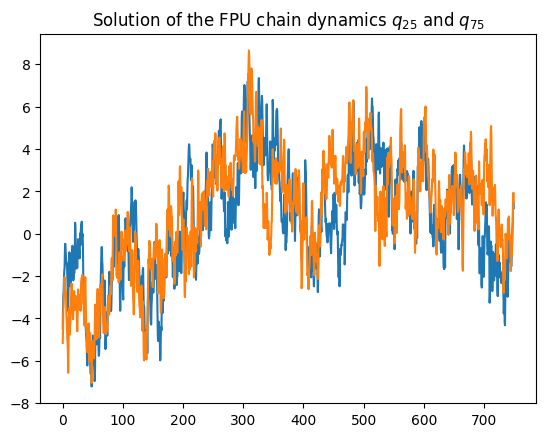

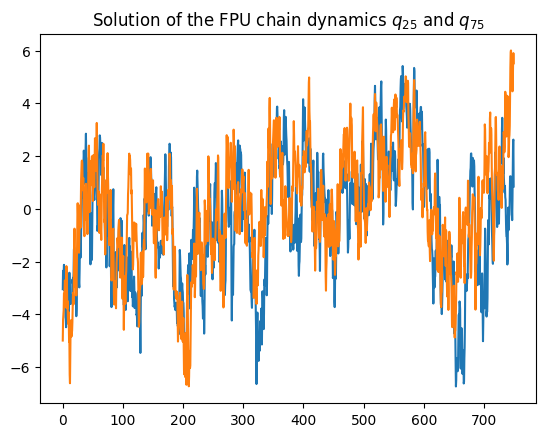

In [9]:
plt.figure(0)
plt.plot(t_store[Toss:]-t_store[Toss],q25_store[:,0])
plt.plot(t_store[Toss:]-t_store[Toss],q75_store[:,0])
plt.title(r"Solution of the FPU chain dynamics $q_{25}$ and $q_{75}$")

plt.figure(1)
plt.plot(t_store[Toss:]-t_store[Toss],q25_store[:,1])
plt.plot(t_store[Toss:]-t_store[Toss],q75_store[:,1])
plt.title(r"Solution of the FPU chain dynamics $q_{25}$ and $q_{75}$")

(400, 400) (400, 400) (400, 400)
(400, 400) (400, 400, 2)


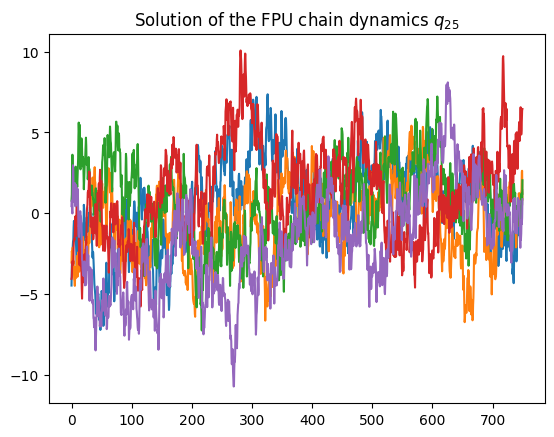

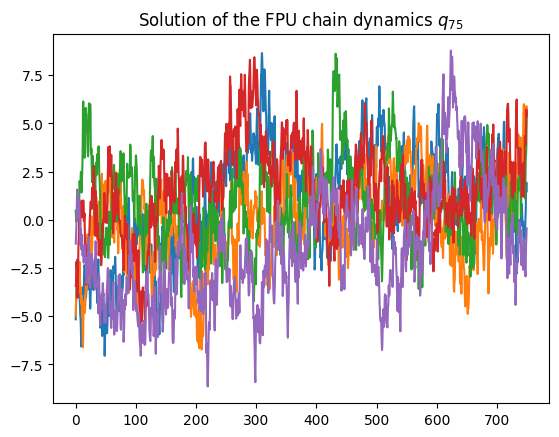

In [10]:
plt.figure(0)
for i in range(5):
    plt.plot(t_store[Toss:]-t_store[Toss],q25_store[:,i])
plt.title(r"Solution of the FPU chain dynamics $q_{25}$")

plt.figure(1)
for i in range(5):
    plt.plot(t_store[Toss:]-t_store[Toss],q75_store[:,i])
plt.title(r"Solution of the FPU chain dynamics $q_{75}$")

###########################################   Construct the sample traj for the LSTM learning 
ini=np.random.randn(sec_length,batch)
Traj25 = q25_store[0:sec_length,:]
Traj75 = q75_store[0:sec_length,:]
print(ini.shape, Traj25.shape, Traj75.shape)

Traj = np.empty((sec_length,batch,2))
Traj[:,:,0] = Traj25
Traj[:,:,1] = Traj75
T=np.arange(len(Traj[:,1]))*delta_t
x=np.linspace(-5,5,sec_length)
print(ini.shape, Traj.shape)

In [11]:
# Reformulating data into Torch tensors 
# Input of SINN should be of the form (seq_len, batch, input_size)

ini = np.random.randn(2*sec_length,2*batch).astype(np.float32) 
input = torch.from_numpy(ini.reshape(2*sec_length, batch, 2)).to(device)
batch_validation = batch
val_set = torch.normal(0.0, 1.0, (2*sec_length, batch_validation, 2), device=device)


Traj = Traj.astype(np.float32) 
target = torch.from_numpy(Traj.reshape(sec_length, batch, 2)).to(device)
print('The torch input size is', input.size(), input.dtype)
print('The torch validation size is', val_set.size(), val_set.dtype)
print('The torch target size is', target.size(), target.dtype)

The torch input size is torch.Size([800, 400, 2]) torch.float32
The torch validation size is torch.Size([800, 400, 2]) torch.float32
The torch target size is torch.Size([400, 400, 2]) torch.float32


In [12]:
# Defining Loss functions
LAGS = 400
N = 400
loss_acf_fft = make_loss('acf[fft]', target, lags=LAGS, device=device)
loss_acf_sec_moment = make_loss('acf[fft]', target**2, lags=LAGS, device=device)
loss_acf_bruteforce = make_loss('acf[bruteforce]', target, lags=LAGS, device=device)
loss_acf_randbrute = make_loss('acf[randombrute]', target, lags=LAGS, sample_lags=20, device=device)

loss_ccf_fft = make_loss('ccf[fft]', target, lags=LAGS, device=device)
loss_ccf_sec_moment = make_loss('ccf[fft]', target**2, lags=LAGS, device=device)
loss_ccf_bruteforce = make_loss('ccf[bruteforce]', target, lags=LAGS, device=device)
loss_ccf_randbrute = make_loss('ccf[randombrute]', target, lags=LAGS, sample_lags=20, device=device)

loss_pdf_empirical1 = make_loss('pdf', target, lower=-5, upper=5, n=N, bw=None, device=device)
loss_pdf_empirical2 = make_loss('pdf6', target, lower=-5, upper=5, n=N, bw=None, device=device)
loss_pdf_empirical2D = make_loss('pdf2D', target, lower=-5, upper=5, n=N, bw=None, device=device)

torch.Size([400, 2])


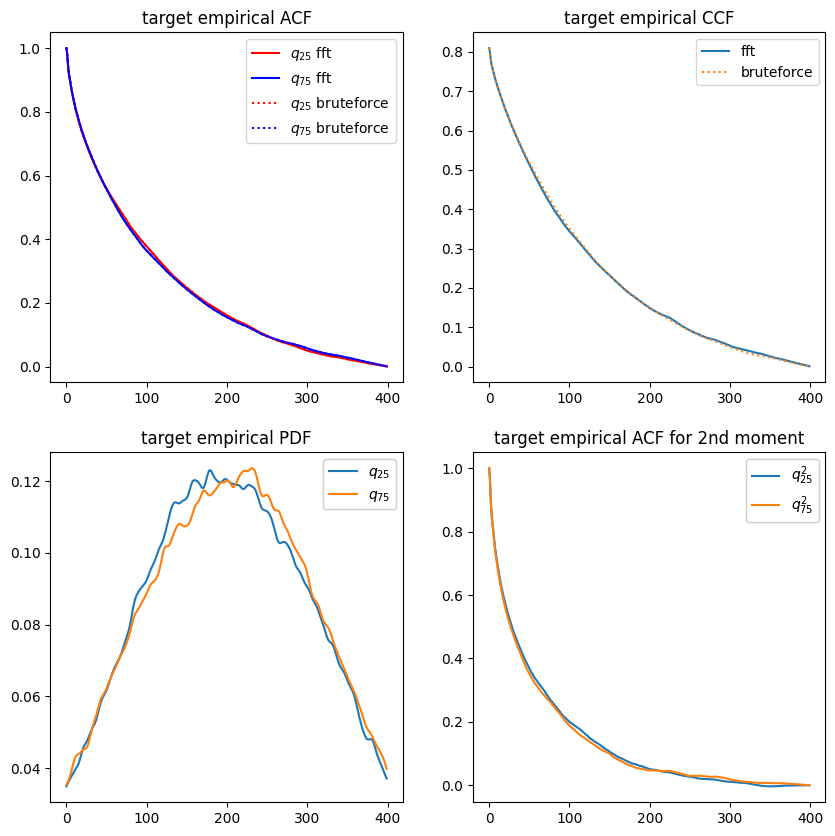

In [13]:
# Plotting target ACFs and PDF
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0,0].plot(loss_acf_fft._target.cpu()[...,0],'r', label=r'$q_{25}$ fft')
axs[0,0].plot(loss_acf_fft._target.cpu()[...,1],'b', label=r'$q_{75}$ fft')
axs[0,0].plot(loss_acf_bruteforce._target.cpu()[...,0],'r:', label= r'$q_{25}$ bruteforce')
axs[0,0].plot(loss_acf_bruteforce._target.cpu()[...,1], 'b:', label=r'$q_{75}$ bruteforce')
axs[0,0].legend()
axs[0,0].set_title('target empirical ACF')

axs[0,1].plot(loss_ccf_fft._target.cpu()[...,1:3], label='fft')
axs[0,1].plot(loss_ccf_bruteforce._target.cpu()[...,1:3],':',label='bruteforce')
# legend2 = axs[0,1].legend(iter(bf), ('q bf', 'p bf'), loc=1)
# axs[0,1].add_artist(legend2)
axs[0,1].legend()
axs[0,1].set_title('target empirical CCF')

x_grid=-np.linspace(-5,5,num=sec_length)
pdf = axs[1,0].plot(loss_pdf_empirical1._target.cpu())
legend3 = axs[1,0].legend(iter(pdf), (r'$q_{25}$',r'$q_{75}$'), loc=1)
axs[1,0].add_artist(legend3)
axs[1,0].set_title('target empirical PDF')


print(loss_acf_sec_moment._target.cpu().size())
sec_moment = axs[1,1].plot(loss_acf_sec_moment._target.cpu())
legend4 = axs[1,1].legend(iter(sec_moment), (r'$q_{25}^2$',r'$q_{75}^2$'),loc=1)
axs[1,1].set_title('target empirical ACF for 2nd moment')
axs[1,1].add_artist(legend4)

plt.show()

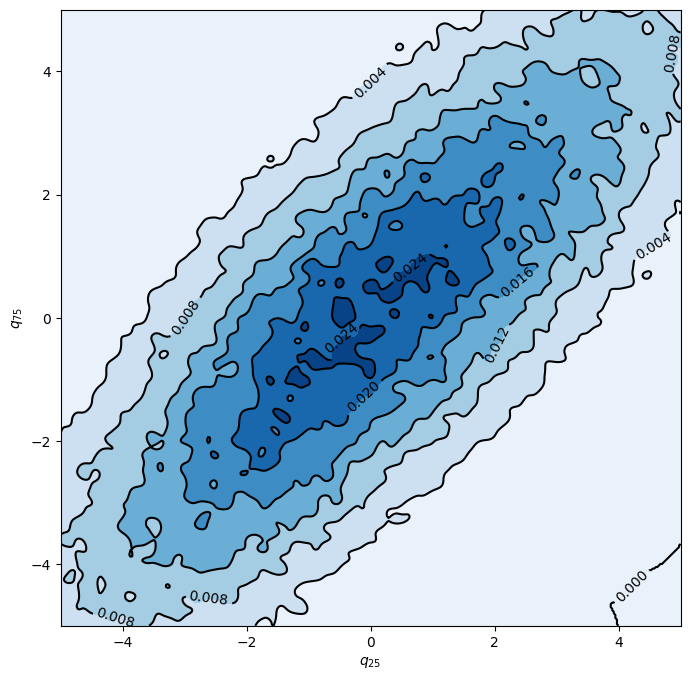

In [14]:
xmin, xmax = -5, 5
ymin, ymax = -5, 5

xx, yy = np.mgrid[xmin:xmax:400j, ymin:ymax:400j]
fig = plt.figure(figsize=(8, 8))
ax = fig.gca()
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# Contourf plot
cfset = ax.contourf(xx, yy, loss_pdf_empirical2D._target.cpu(), cmap='Blues')
## Or kernel density estimate plot instead of the contourf plot

# Contour plot
cset = ax.contour(xx, yy, loss_pdf_empirical2D._target.cpu(), colors='k')
# Label plot
ax.clabel(cset, inline=1, fontsize=10)
ax.set_xlabel(r'$q_{25}$')
ax.set_ylabel(r'$q_{75}$')

plt.show()

Text(0.5, 1.0, 'target empirical PDF')

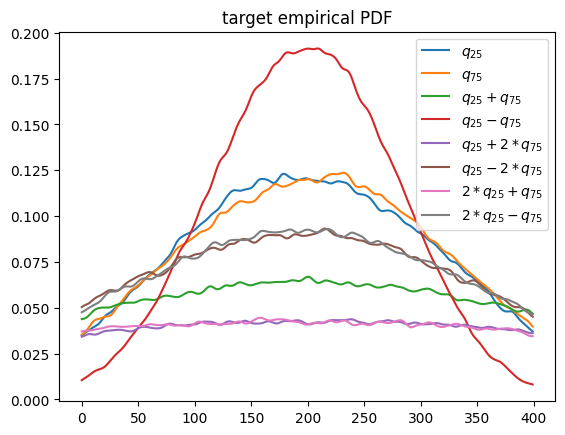

In [15]:
x_grid=-np.linspace(-5,5,num=sec_length)
plt.plot(loss_pdf_empirical1._target.cpu()[...,0],label=r'$q_{25}$')
plt.plot(loss_pdf_empirical1._target.cpu()[...,1],label=r'$q_{75}$')
plt.plot(loss_pdf_empirical2._target.cpu()[...,0],label=r'$q_{25}+q_{75}$')
plt.plot(loss_pdf_empirical2._target.cpu()[...,1],label=r'$q_{25}-q_{75}$')
plt.plot(loss_pdf_empirical2._target.cpu()[...,2],label=r'$q_{25}+2*q_{75}$')
plt.plot(loss_pdf_empirical2._target.cpu()[...,3],label=r'$q_{25}-2*q_{75}$')
plt.plot(loss_pdf_empirical2._target.cpu()[...,4],label=r'$2*q_{25}+q_{75}$')
plt.plot(loss_pdf_empirical2._target.cpu()[...,5],label=r'$2*q_{25}-q_{75}$')
plt.legend()
plt.title('target empirical PDF')

In [16]:
class Model:
    def __init__(self, net):

        self.x_acf_s = None
        self.x_ccf_s = None
        self.x_pdf_s = None
        self.x_pdf2_s = None
        self.x_acf2_s = None
        self.s_collect = []

        self.net = net

        self.T_error=[]
        self.V_error=[]
        self.T_ccf=[]
        self.V_ccf=[]
        self.T_pdf=[]
        self.V_pdf=[]
        self.T_pdf2=[]
        self.V_pdf2=[]
        self.T_acf=[]
        self.V_acf=[]
        self.T_acf2=[]
        self.V_acf2=[]
        self.Step=[]
        self.iter = 0
        self.time = 0

    def train_U(self, x):
        return self.net(x)

    def predict_U(self, x):
        return self.train_U(x)

    def likelihood_loss(self, loss_acf, loss_ccf, loss_pdf, loss_pdf2, loss_acf2):
        loss = torch.reciprocal(2. * self.x_acf_s ** 2) * loss_acf.detach()      \
               + torch.reciprocal(2. * self.x_ccf_s ** 2) * loss_ccf.detach()    \
               + torch.reciprocal(2. * self.x_pdf_s ** 2) * loss_pdf.detach()    \
               + torch.reciprocal(2. * self.x_pdf2_s ** 2) * loss_pdf2.detach()  \
               + torch.reciprocal(2. * self.x_acf2_s ** 2) * loss_acf2.detach()  \
               + torch.log(self.x_acf_s * self.x_ccf_s * self.x_pdf_s * self.x_pdf2_s * self.x_acf2_s)
        return loss

    def true_loss(self, loss_acf, loss_ccf, loss_pdf, loss_pdf2, loss_acf2):
        return torch.reciprocal(2. * self.x_acf_s.detach() ** 2) * loss_acf + torch.reciprocal(2. * self.x_ccf_s.detach() ** 2) * loss_ccf + torch.reciprocal(2. * self.x_pdf_s.detach() ** 2) * loss_pdf + torch.reciprocal(2. * self.x_pdf2_s.detach() ** 2) * loss_pdf2 + torch.reciprocal(2. * self.x_acf2_s.detach() ** 2) * loss_acf2

    def run_baseline(self):
        optimizer_adam = optim.Adam(self.net.parameters(), lr=1e-3)
        for step in range(20000):
            optimizer_adam.zero_grad()
            ini = np.random.randn(2*sec_length, batch*self.net.lstm.input_size).astype(np.float32) 
            input = torch.from_numpy(ini.reshape(2*sec_length, batch, self.net.lstm.input_size)).to(device)
            prediction, _ = self.train_U(input)
            prediction = prediction[-LAGS:,:,:]
            loss = loss_acf_fft(prediction)+ loss_ccf_fft(prediction)+loss_pdf_empirical1(prediction)+loss_pdf_empirical2(prediction)+loss_acf_sec_moment(prediction**2)
            loss.backward()
            optimizer_adam.step()
            self.iter += 1
            if step % 50 == 0: 
                with torch.no_grad():
                    loss = loss_acf_fft(prediction)+loss_ccf_fft(prediction)+loss_pdf_empirical1(prediction)+loss_pdf_empirical2(prediction)+loss_acf_sec_moment(prediction**2)
                    pred_val, _ = self.predict_U(val_set)
                    pred_val = pred_val[-LAGS:,:,:]
                    loss_val = loss_acf_bruteforce(pred_val)+loss_ccf_bruteforce(pred_val)+ loss_pdf_empirical1(pred_val)+ loss_pdf_empirical2(pred_val) + loss_acf_sec_moment(pred_val**2)
                    acf = loss_acf_bruteforce(pred_val)
                    ccf = loss_ccf_bruteforce(pred_val)
                    pdf = loss_pdf_empirical1(pred_val)
                    pdf2 = loss_pdf_empirical2(pred_val)
                    acf_sec_moment = loss_acf_sec_moment(pred_val**2)
                    print('[%d]-th step loss: %.4f, %.4f, acf: %.5f, ccf: %.5f, pdf: %.5f, pdf2: %.5f, acf2: %.5f' % (step, loss, loss_val, acf, ccf, pdf, pdf2, acf_sec_moment))
                    self.T_acf.append(loss_acf_fft(prediction).detach().cpu().numpy())
                    self.V_acf.append(loss_acf_bruteforce(pred_val).detach().cpu().numpy())
                    self.T_ccf.append(loss_ccf_fft(prediction).detach().cpu().numpy())
                    self.V_ccf.append(loss_ccf_bruteforce(pred_val).detach().cpu().numpy())
                    self.T_pdf.append(loss_pdf_empirical1(prediction).detach().cpu().numpy())
                    self.V_pdf.append(loss_pdf_empirical1(pred_val).detach().cpu().numpy())
                    self.T_pdf2.append(loss_pdf_empirical2(prediction).detach().cpu().numpy())
                    self.V_pdf2.append(loss_pdf_empirical2(pred_val).detach().cpu().numpy())
                    self.T_acf2.append(loss_acf_sec_moment(prediction**2).detach().cpu().numpy())
                    self.V_acf2.append(loss_acf_sec_moment(pred_val**2).detach().cpu().numpy())
                    self.T_error.append(loss.detach().cpu().numpy())
                    self.V_error.append(loss_val.detach().cpu().numpy())
                    self.Step.append(step)
            if loss <= 0.0005 and loss_val <= 0.0005:
                break

        if loss > 0.0005 or loss_val > 0.0005:
            print ('Training failed')
        print('Training finished')



    def run_AW(self):
        self.x_acf_s = nn.Parameter(self.x_acf_s, requires_grad=True)
        self.x_ccf_s = nn.Parameter(self.x_ccf_s, requires_grad=True)
        self.x_pdf_s = nn.Parameter(self.x_pdf_s, requires_grad=True)
        self.x_pdf2_s = nn.Parameter(self.x_pdf2_s, requires_grad=True)
        self.x_acf2_s = nn.Parameter(self.x_acf2_s, requires_grad=True)


        optimizer_adam = optim.Adam(self.net.parameters(), lr=1e-3)
        optimizer_adam_weight = optim.Adam([self.x_acf_s] + [self.x_ccf_s] + [self.x_pdf_s] + [self.x_pdf2_s] + [self.x_acf2_s],
                                                     lr=1e-3)

        for step in range(20000):
            self.s_collect.append([self.iter, self.x_acf_s.item(), self.x_ccf_s.item(), self.x_pdf_s.item(), self.x_pdf2_s.item(), self.x_acf2_s.item()])

            optimizer_adam.zero_grad()
            ini = np.random.randn(2*sec_length, batch*self.net.lstm.input_size).astype(np.float32) 
            input = torch.from_numpy(ini.reshape(2*sec_length, batch, self.net.lstm.input_size)).to(device)
            prediction, _ = self.train_U(input)
            prediction = prediction[-LAGS:,:,:]
            loss = self.true_loss(loss_acf_fft(prediction), loss_ccf_fft(prediction),loss_pdf_empirical1(prediction),loss_pdf_empirical2(prediction),loss_acf_sec_moment(prediction**2))
            loss.backward()
            optimizer_adam.step()
            self.iter += 1
            if step % 50 == 0: 
                with torch.no_grad():
                    loss = loss_acf_fft(prediction)+loss_ccf_fft(prediction)+loss_pdf_empirical1(prediction)+loss_pdf_empirical2(prediction)+loss_acf_sec_moment(prediction**2)
                    pred_val, _ = self.predict_U(val_set)
                    pred_val = pred_val[-LAGS:,:,:]
                    loss_val = loss_acf_bruteforce(pred_val)+loss_ccf_bruteforce(pred_val)+ loss_pdf_empirical1(pred_val) + loss_pdf_empirical2(pred_val) + loss_acf_sec_moment(pred_val**2)
                    acf = loss_acf_bruteforce(pred_val)
                    ccf = loss_ccf_bruteforce(pred_val)
                    pdf = loss_pdf_empirical1(pred_val)
                    pdf2 = loss_pdf_empirical2(pred_val)
                    acf_sec_moment = loss_acf_sec_moment(pred_val**2)
                    print('[%d]-th step loss: %.4f, %.4f, acf: %.5f, ccf: %.5f, pdf: %.5f, pdf2: %.5f, acf2: %.5f' % (step, loss, loss_val, acf, ccf, pdf, pdf2, acf_sec_moment))
                    self.T_acf.append(loss_acf_fft(prediction).detach().cpu().numpy())
                    self.V_acf.append(loss_acf_bruteforce(pred_val).detach().cpu().numpy())
                    self.T_ccf.append(loss_ccf_fft(prediction).detach().cpu().numpy())
                    self.V_ccf.append(loss_ccf_bruteforce(pred_val).detach().cpu().numpy())
                    self.T_pdf.append(loss_pdf_empirical1(prediction).detach().cpu().numpy())
                    self.V_pdf.append(loss_pdf_empirical1(pred_val).detach().cpu().numpy())
                    self.T_pdf2.append(loss_pdf_empirical2(prediction).detach().cpu().numpy())
                    self.V_pdf2.append(loss_pdf_empirical2(pred_val).detach().cpu().numpy())
                    self.T_acf2.append(loss_acf_sec_moment(prediction**2).detach().cpu().numpy())
                    self.V_acf2.append(loss_acf_sec_moment(pred_val**2).detach().cpu().numpy())
                    self.T_error.append(loss.detach().cpu().numpy())
                    self.V_error.append(loss_val.detach().cpu().numpy())
                    self.Step.append(step)
            if loss <= 0.0005 and loss_val <= 0.0005:
                break
            optimizer_adam_weight.zero_grad()
            loss = self.likelihood_loss(loss_acf_fft(prediction), loss_ccf_fft(prediction),loss_pdf_empirical1(prediction),loss_pdf_empirical2(prediction),loss_acf_sec_moment(prediction**2))
            loss.backward()
            optimizer_adam_weight.step()
            
        if loss > 0.0005 or loss_val > 0.0005:
            print ('Training failed')
        print('Training finished')


    def train(self):
        self.x_acf_s = torch.tensor(2.).float()
        self.x_ccf_s = torch.tensor(2.).float()
        self.x_pdf_s = torch.tensor(2.).float()
        self.x_pdf2_s = torch.tensor(2.).float()
        self.x_acf2_s = torch.tensor(2.).float()
        start_time = time.time()
        if model_type == 0:
            self.run_baseline()
        elif model_type == 1:
            self.run_AW()
        elapsed = time.time() - start_time
        self.time = elapsed
        print('Training time: %.2f' % elapsed)
        avg_time = elapsed/self.iter
        print('Training time per iteration: %.2f' % avg_time)
        print('Number of Iterations:%d' %self.iter)

In [17]:
model_type = 1

In [18]:
### Defining SINN model
net = SINN(2, 50, 2, 2).to(device) # input dimension, hidden size, number of layers, output dimension
model = Model(net=net)
model.train()

[0]-th step loss: 0.8243, 0.8193, acf: 0.10139, ccf: 0.08446, pdf: 0.29301, pdf2: 0.29513, acf2: 0.04529
[50]-th step loss: 0.1521, 0.1405, acf: 0.02089, ccf: 0.01837, pdf: 0.04917, pdf2: 0.04184, acf2: 0.01027
[100]-th step loss: 0.0394, 0.0426, acf: 0.00305, ccf: 0.00418, pdf: 0.01158, pdf2: 0.01300, acf2: 0.01082
[150]-th step loss: 0.0338, 0.0303, acf: 0.00511, ccf: 0.00601, pdf: 0.00655, pdf2: 0.00966, acf2: 0.00300
[200]-th step loss: 0.0222, 0.0216, acf: 0.00407, ccf: 0.00534, pdf: 0.00333, pdf2: 0.00668, acf2: 0.00216
[250]-th step loss: 0.0159, 0.0153, acf: 0.00158, ccf: 0.00441, pdf: 0.00267, pdf2: 0.00538, acf2: 0.00125
[300]-th step loss: 0.0342, 0.0345, acf: 0.00417, ccf: 0.00470, pdf: 0.00772, pdf2: 0.01058, acf2: 0.00738
[350]-th step loss: 0.2546, 0.2525, acf: 0.08699, ccf: 0.07272, pdf: 0.00833, pdf2: 0.05046, acf2: 0.03401
[400]-th step loss: 0.1113, 0.0909, acf: 0.01654, ccf: 0.01396, pdf: 0.00833, pdf2: 0.05049, acf2: 0.00162
[450]-th step loss: 0.0682, 0.0683, acf:

[3850]-th step loss: 0.0005, 0.0012, acf: 0.00018, ccf: 0.00017, pdf: 0.00005, pdf2: 0.00002, acf2: 0.00073
[3900]-th step loss: 0.0010, 0.0007, acf: 0.00033, ccf: 0.00017, pdf: 0.00006, pdf2: 0.00003, acf2: 0.00017
[3950]-th step loss: 0.0008, 0.0008, acf: 0.00025, ccf: 0.00012, pdf: 0.00006, pdf2: 0.00003, acf2: 0.00031
[4000]-th step loss: 0.0005, 0.0008, acf: 0.00035, ccf: 0.00036, pdf: 0.00003, pdf2: 0.00001, acf2: 0.00010
[4050]-th step loss: 0.0005, 0.0009, acf: 0.00015, ccf: 0.00013, pdf: 0.00009, pdf2: 0.00002, acf2: 0.00052
[4100]-th step loss: 0.0004, 0.0009, acf: 0.00023, ccf: 0.00015, pdf: 0.00007, pdf2: 0.00002, acf2: 0.00043
[4150]-th step loss: 0.0008, 0.0018, acf: 0.00046, ccf: 0.00058, pdf: 0.00023, pdf2: 0.00006, acf2: 0.00049
[4200]-th step loss: 0.0006, 0.0006, acf: 0.00026, ccf: 0.00015, pdf: 0.00003, pdf2: 0.00001, acf2: 0.00014
[4250]-th step loss: 0.0003, 0.0006, acf: 0.00025, ccf: 0.00014, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00018
[4300]-th step loss: 0.0009,

In [19]:
def draw_loss(model):
    ### Plotting the training and the generalization error
    fig = plt.figure(1)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Error plot",fontsize=15) 
    plt.yscale('log')
    plt.plot(model.Step, model.T_error,'r',label='Training error')
    plt.plot(model.Step, model.V_error,'b--',label='Validation error')
#     plt.loglog(model.Step, model.T_error,'r',label='Training error')
#     plt.loglog(model.Step, model.V_error,'b--',label='Validation error')
    plt.xlabel(r'Training times $n$',fontsize=15)
    plt.ylabel(r'$l_1+l_2$',fontsize=15)
    plt.legend(frameon=False,fontsize=15)

In [20]:
def draw_errors(model):
    ### Plotting the training and the generalization error
    fig = plt.figure(1)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Error plot for loss functions w/o coeff",fontsize=15)
    plt.yscale('log')
    plt.plot(model.Step, model.T_error,'k',label='Training error')
    plt.plot(model.Step, model.V_error,'k--')
    plt.plot(model.Step, model.T_acf,'r',label='acf error')
    plt.plot(model.Step, model.V_acf,'r--')
    plt.plot(model.Step, model.T_ccf,'b',label='ccf error')
    plt.plot(model.Step, model.V_ccf,'b--')
    plt.plot(model.Step, model.T_pdf,'y',label='pdf error')
    plt.plot(model.Step, model.V_pdf,'y--')
    plt.plot(model.Step, model.T_pdf2,'m',label='pdf2 error')
    plt.plot(model.Step, model.V_pdf2,'m--')
    plt.plot(model.Step, model.T_acf2,'g',label='acf2 error')
    plt.plot(model.Step, model.V_acf2,'g--')
    
#     plt.loglog(model.Step, model.T_error,'k',label='Training error')
#     plt.loglog(model.Step, model.V_error,'k--')
#     plt.loglog(model.Step, model.T_acf,'r',label='acf error')
#     plt.loglog(model.Step, model.V_acf,'r--')
#     plt.loglog(model.Step, model.T_ccf,'b',label='ccf error')
#     plt.loglog(model.Step, model.V_ccf,'b--')
#     plt.loglog(model.Step, model.T_pdf,'y',label='pdf error')
#     plt.loglog(model.Step, model.V_pdf,'y--')
#     plt.loglog(model.Step, model.T_pdf2,'m',label='pdf2 error')
#     plt.loglog(model.Step, model.V_pdf2,'m--')
#     plt.loglog(model.Step, model.T_acf2,'g',label='acf2 error')
#     plt.loglog(model.Step, model.V_acf2,'g--')
    plt.xlabel(r'Training times $n$',fontsize=15)
    plt.ylabel(r'$l_1+l_2$',fontsize=15)
    plt.legend(frameon=False,fontsize=15, bbox_to_anchor=(1.1, 1.05))

In [21]:
def draw_adaptive_w(model):
    s_collect = np.array(model.s_collect)
    np.savetxt('s_RAM-AW.npy', s_collect)
#     plt.yscale('log')
    plt.plot(s_collect[:, 0], s_collect[:, 1], 'r-', label=r'$\epsilon_{acf}$')
    plt.plot(s_collect[:, 0], s_collect[:, 2], 'b-', label='$\epsilon_{ccf}$')
    plt.plot(s_collect[:, 0], s_collect[:, 3], 'y-', label='$\epsilon_{pdf}$')
    plt.plot(s_collect[:, 0], s_collect[:, 4], 'm-', label='$\epsilon_{pdf2}$')
    plt.plot(s_collect[:, 0], s_collect[:, 5], 'g-', label='$\epsilon_{acf2}$')
    plt.xlabel('$Iters$')
    plt.ylabel('$s$')
#     plt.xscale('log')
    plt.legend()
#     plt.savefig('2dpossion_S_RAM-AW.pdf')
    plt.show()

In [22]:
def draw_epoch_w(model):
    s_collect = np.array(model.s_collect)
    np.savetxt('s_RAM-AW.npy', s_collect)
    plt.yscale('log')
    plt.plot(s_collect[:, 0], np.reciprocal(2. * s_collect[:, 1]**2), 'r-', label=r'$\frac{1}{2\epsilon_{acf}^2}$')
    plt.plot(s_collect[:, 0], np.reciprocal(2. * s_collect[:, 2]**2), 'b-', label=r'$\frac{1}{2\epsilon_{ccf}^2}$')
    plt.plot(s_collect[:, 0], np.reciprocal(2. * s_collect[:, 3]**2), 'y-', label=r'$\frac{1}{2\epsilon_{pdf}^2}$')
    plt.plot(s_collect[:, 0], np.reciprocal(2. * s_collect[:, 4]**2), 'm-', label=r'$\frac{1}{2\epsilon_{pdf2}^2}$')
    plt.plot(s_collect[:, 0], np.reciprocal(2. * s_collect[:, 5]**2), 'g-', label=r'$\frac{1}{2\epsilon_{acf2}^2}$')
    plt.xlabel('$Iters$')
    plt.ylabel('$\omega$')
    plt.legend()
#     plt.savefig('2dpossion_S_RAM-AW.pdf')
    plt.show()

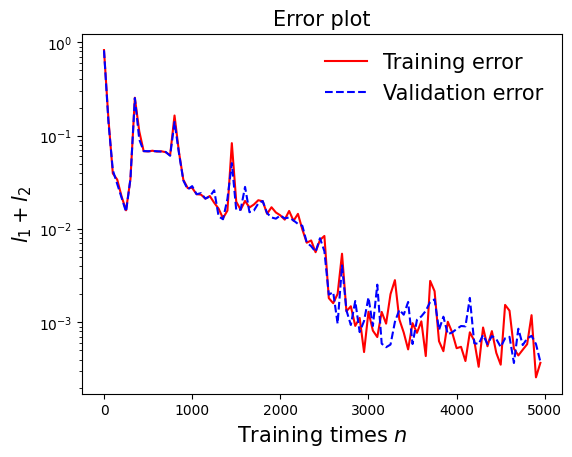

In [23]:
draw_loss(model)

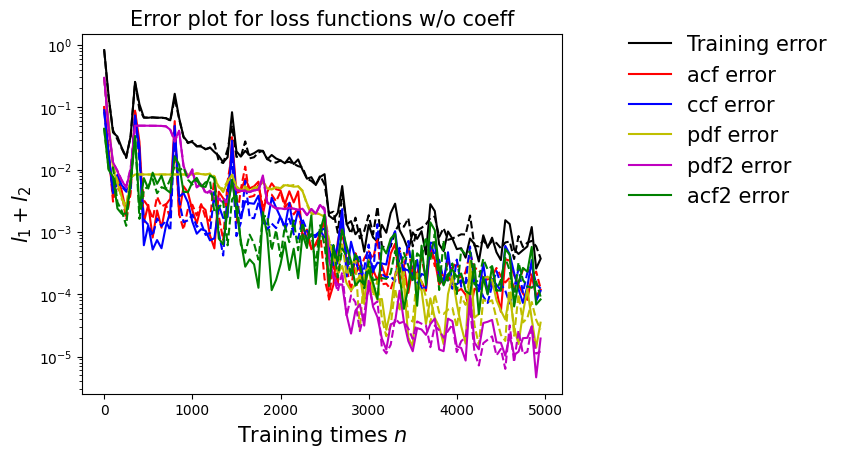

In [24]:
draw_errors(model)

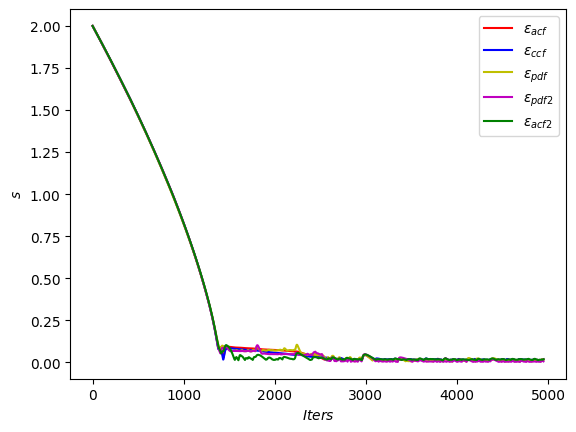

In [25]:
draw_adaptive_w(model)

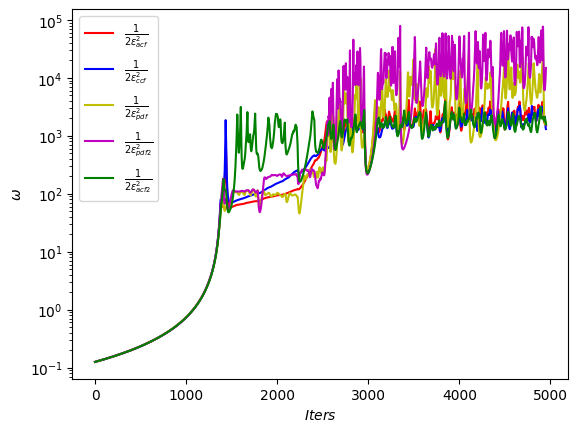

In [26]:
draw_epoch_w(model)

## Test 1: plot the sample path generated by SINN and the exact sample path 

In [27]:
def test1(model):
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= model.predict_U(ran_input)
    prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch, 2)
    # Test 1: plot the sample path generated by SINN and the exact sample path 
    skip = 0

    fig = plt.figure(0)
    plt.title("MD trajectories",fontsize=15) 
    plt.plot(T[skip:]-T[skip], Traj[skip:, 0])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$q_{25}(t)$ and $q_{75}(t)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15) 


    fig = plt.figure(1)
    plt.title("SINN trajectories",fontsize=15)    
    plt.plot(T[skip:]-T[skip], prediction[skip:, 0])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$q_{25}(t)$ and $q_{75}(t)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

## Test 2: plot the CCF of the sample path generated by the SINN and the exact CCF

In [28]:
def test2(model):
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= model.predict_U(ran_input)
    
    # Test 2: plot the CCF of the sample path generated by the SINN and the exact CCF  
    acf_p=StatLoss.acf(Pred[-sec_length:,:,:])
    acf_t=StatLoss.acf(target)
    corr_p1=acf_p.detach().cpu().numpy()
    corr_t1=acf_t.detach().cpu().numpy()
    ccf_p=StatLoss.ccf(Pred[-sec_length:,:,:])
    ccf_t=StatLoss.ccf(target)
    corr_p2=ccf_p.detach().cpu().numpy()
    corr_t2=ccf_t.detach().cpu().numpy()
    
    fig = plt.figure(0)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized ACF of $\tilde{q}_1$',fontsize=15)    
    plt.plot(T, corr_t1[...,0],'r',label='Exact')        # correlation function of the target 
    plt.plot(T, corr_p1[...,0], 'b--',label='SINN')        # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
#     plt.xlim(0,T[-1])
    plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
    plt.legend()
    
    fig = plt.figure(1)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized ACF of $\tilde{q}_2$',fontsize=15)          
    plt.plot(T, corr_t1[...,-1],'r',label='Exact')        # correlation function of the target 
    plt.plot(T, corr_p1[...,-1], 'b--',label='SINN')     # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
#     plt.xlim(0,T[-1])
    plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
    plt.legend()
    
    fig = plt.figure(2)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized CCF',fontsize=15)    
    plt.plot(T, corr_t2[:,:],'r')        # correlation function of the target 
    plt.plot(T, corr_p2[:,:], 'b--')        # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
#     plt.ylim(-0.05,0.05)

## Test 3: plot the PDF of the sample path generated by SINN and the exact PDF  

In [29]:
def test3(model):
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= model.predict_U(ran_input)
    
    # Test 3: plot the PDF of the sample path generated by SINN and the exact PDF  
    rho_data =  StatLoss.gauss_kde(target, -5, 5, 400, None).cpu()
    rho_input = StatLoss.gauss_kde(ran_input, -5, 5, 400, None).cpu()
    rho_prediction = StatLoss.gauss_kde(Pred[-sec_length:,:,:].detach(), -5, 5, 400,None).cpu()
    
    rho_data2 =  StatLoss.gauss_kde6(target, -5, 5, 400, None).cpu()
    rho_prediction2 = StatLoss.gauss_kde6(Pred[-sec_length:,:,:].detach(), -5, 5, 400,None).cpu()


    x=np.linspace(-5, 5, 400)
    fig = plt.figure(0)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r"Equilibrium probability density function",fontsize=15)    
    plt.plot(x, rho_data.numpy()[...,0],label=r'Exact PDF of $q_{25}$')    # target PDF
    plt.plot(x, rho_data.numpy()[...,1],label=r'Exact PDF of $q_{75}$')    # target PDF
#     plt.plot(x, rho_input.numpy(), 'b--', label=r'PDF of the input')     # PDF of the input
    plt.plot(x, rho_prediction.numpy()[...,0], ':',label=r'PDF of the output $q_{25}$')  # PDF after the training 
    plt.plot(x, rho_prediction.numpy()[...,1], ':',label=r'PDF of the output $q_{75}$')  # PDF after the training 
    plt.xlim(-5,5)
#     plt.ylim(0,0.6)
    plt.xlabel(r'$x$',fontsize=15)
    plt.ylabel(r'$\rho(x)$',fontsize=15)
    plt.legend(frameon=False,fontsize=10)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
    
    fig = plt.figure(1)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r"Equilibrium probability density function of sum and diff",fontsize=15)    
    plt.plot(x, rho_data2.numpy()[...,0],label=r'Exact PDF of $q_{25}+q_{75}$')    # target PDF
    plt.plot(x, rho_data2.numpy()[...,1],label=r'Exact PDF of $q_{25}-q_{75}$')    # target PDF
#     plt.plot(x, rho_input.numpy(), 'b--', label=r'PDF of the input')     # PDF of the input
    plt.plot(x, rho_prediction2.numpy()[...,0], ':',label=r'PDF of the output $q_{25}+q_{75}$')  # PDF after the training 
    plt.plot(x, rho_prediction2.numpy()[...,1], ':',label=r'PDF of the output $q_{25}-q_{75}$')  # PDF after the training 
    plt.xlim(-5,5)
#     plt.ylim(0,0.6)
    plt.xlabel(r'$x$',fontsize=15)
    plt.ylabel(r'$\rho(x)$',fontsize=15)
    plt.legend(frameon=False,fontsize=10)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
    fig = plt.figure(2)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r"Equilibrium probability density function of sum and diff",fontsize=15)    
    plt.plot(x, rho_data2.numpy()[...,2],label=r'Exact PDF of $q_{25}+2q_{75}$')    # target PDF
    plt.plot(x, rho_data2.numpy()[...,3],label=r'Exact PDF of $q_{25}-2q_{75}$')    # target PDF
#     plt.plot(x, rho_input.numpy(), 'b--', label=r'PDF of the input')     # PDF of the input
    plt.plot(x, rho_prediction2.numpy()[...,2], ':',label=r'PDF of the output $q_{25}+2q_{75}$')  # PDF after the training 
    plt.plot(x, rho_prediction2.numpy()[...,3], ':',label=r'PDF of the output $q_{25}-2q_{75}$')  # PDF after the training 
    plt.xlim(-5,5)
#     plt.ylim(0,0.6)
    plt.xlabel(r'$x$',fontsize=15)
    plt.ylabel(r'$\rho(x)$',fontsize=15)
    plt.legend(frameon=False,fontsize=10)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
    fig = plt.figure(3)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r"Equilibrium probability density function of sum and diff",fontsize=15)    
    plt.plot(x, rho_data2.numpy()[...,4],label=r'Exact PDF of $2q_{25}+q_{75}$')    # target PDF
    plt.plot(x, rho_data2.numpy()[...,5],label=r'Exact PDF of $2q_{25}-q_{75}$')    # target PDF
#     plt.plot(x, rho_input.numpy(), 'b--', label=r'PDF of the input')     # PDF of the input
    plt.plot(x, rho_prediction2.numpy()[...,4], ':',label=r'PDF of the output $2q_{25}+q_{75}$')  # PDF after the training 
    plt.plot(x, rho_prediction2.numpy()[...,5], ':',label=r'PDF of the output $2q_{25}-q_{75}$')  # PDF after the training 
    plt.xlim(-5,5)
#     plt.ylim(0,0.6)
    plt.xlabel(r'$x$',fontsize=15)
    plt.ylabel(r'$\rho(x)$',fontsize=15)
    plt.legend(frameon=False,fontsize=10)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

## Test 4: Comparing the higher-order ACF

In [30]:
def test4(model):
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= model.predict_U(ran_input)
    prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch, 2)
    
    # Test 4: Comparing the higher-order ACF
    acf2=StatLoss.acf(target**2)
    pred_norm=torch.from_numpy((prediction).reshape(sec_length, batch,2))
    acf2_app=StatLoss.acf(pred_norm**2)

    
    fig = plt.figure(0)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized ACF of $q_{25}^2$',fontsize=15)    
    plt.plot(T, acf2.detach().cpu().numpy()[...,0],'r',label='Exact')        # correlation function of the target 
    plt.plot(T, acf2_app.detach().cpu().numpy()[...,0], 'b--',label='SINN')        # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.xlim(0,T[-1])
    plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
    plt.legend()
    
    fig = plt.figure(1)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized ACF of $q_{75}^2$',fontsize=15)          
    plt.plot(T, acf2.detach().cpu().numpy()[...,1],'r',label='Exact')        # correlation function of the target 
    plt.plot(T, acf2_app.detach().cpu().numpy()[...,1], 'b--',label='SINN')     # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.xlim(0,T[-1])
    plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
    plt.legend()    

## Test 5: plot the expolation result, i.e. Prediction of the FPU-Langevin dynamics for longer time 

In [31]:
def test5(model):
    # Test 5: plot the expolation result, i.e. Prediction of the FPU-Langevin dynamics for longer time 
    [a,b,c]=input.size()
    skip=20
    scale=10
    burnin=3
    fold=800
    batch_new=50
    ran_input=torch.randn(((scale-burnin)*a,batch_new,c),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred_L, _= model.predict_U(ran_input)
    prediction_ext=Pred_L.detach().cpu().numpy().reshape((scale-burnin)*a, batch_new,2)
    ccf_p=StatLoss.ccf(Pred_L,method='bruteforce')

    LT=np.linspace(0,(scale-burnin)*a*delta_t,num=(scale-burnin)*a+1)
    LT=LT[0:-1]


    fig = plt.figure(0)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Short-time trajectories",fontsize=15)
    plt.plot(t_store[Toss:]-t_store[Toss],q25_store[:,0],label='MD simulation')
    plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 0],'--',label='SINN simulation')
    plt.xlim([0,80])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$q_{25}(t)$',fontsize=15)
    plt.legend(frameon=False,fontsize=15)
    plt.yticks([-2,-1,0,1,2],fontsize=15)
    plt.xticks(fontsize=15)



    fig = plt.figure(figsize=(16, 4))
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Long-time trajectories",fontsize=15)
    plt.plot(t_store[Toss:]-t_store[Toss],q25_store[:,0],label='MD simulation')
    plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 0],'--',label='SINN simulation')
    plt.xlim([0,500])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$q_{25}(t)$',fontsize=15)
    plt.legend(frameon=False,fontsize=15)
    plt.yticks([-2,-1,0,1,2],fontsize=15)
    plt.xticks(fontsize=15)

    fig = plt.figure(2)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Short-time trajectories",fontsize=15)
    plt.plot(t_store[Toss:]-t_store[Toss],q75_store[:,0],label='MD simulation')
    plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 1],'--',label='SINN simulation')
    plt.xlim([0,80])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$q_{75}(t)$',fontsize=15)
    plt.legend(frameon=False,fontsize=15)
    plt.yticks([-2,-1,0,1,2],fontsize=15)
    plt.xticks(fontsize=15)



    fig = plt.figure(figsize=(16, 4))
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Long-time trajectories",fontsize=15)
    plt.plot(t_store[Toss:]-t_store[Toss],q75_store[:,0],label='MD simulation')
    plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 1],'--',label='SINN simulation')
    plt.xlim([0,500])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$q_{75}(t)$',fontsize=15)
    plt.legend(frameon=False,fontsize=15)
    plt.yticks([-2,-1,0,1,2],fontsize=15)
    plt.xticks(fontsize=15)

## Test 6: comparing scatter plots

In [32]:
def test6(model):
    # Test 6: scatter plot of SINN
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= model.predict_U(ran_input)
    prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch, 2)
    
    fig = plt.figure(0)
    plt.title("MD trajectories",fontsize=15) 
    plt.scatter(Traj[:,:,0], Traj[:,:,1])
    plt.xlabel(r'$q_{25}(t)$',fontsize=15)
    plt.ylabel(r'$q_{75}(t)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15) 


    fig = plt.figure(1)
    plt.title("SINN trajectories",fontsize=15)    
    plt.scatter(prediction[:,:,0],prediction[:,:,1])
    plt.xlabel(r'$q_{25}(t)$',fontsize=15)
    plt.ylabel(r'$q_{75}(t)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

## Test 7: comparing joint PDF contours

In [33]:
def test7(model):
    # Test 5: scatter plot of SINN
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= model.predict_U(ran_input)
    prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch, 2)
    
    rho_data =  StatLoss.gauss_kde2D(target, -5, 5, 400, None).cpu()
    rho_prediction = StatLoss.gauss_kde2D(Pred[-sec_length:,:,:].detach(), -5, 5, 400,None).cpu()
    
    fig = plt.figure(0, figsize=(5, 5))
    plt.title("PDF Contours",fontsize=15) 
    xmin, xmax = -5, 5
    ymin, ymax = -5, 5

    xx, yy = np.mgrid[xmin:xmax:400j, ymin:ymax:400j]
    axs[0]  = fig.gca()
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    
    plt.contour(xx,yy,rho_data.numpy(),colors='r')
    plt.contour(xx,yy,rho_prediction.numpy(),colors='b',linestyles='dashed')

    plt.xlabel(r'$q_{25}$')
    plt.ylabel(r'$q_{75}$')

    
    
    fig = plt.figure(1,figsize=(5, 5))
    plt.title("MD trajectories",fontsize=15) 
    xmin, xmax = -5, 5
    ymin, ymax = -5, 5

#     xx, yy = np.mgrid[xmin:xmax:20j, ymin:ymax:20j]
    ax  = fig.gca()
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    cfset = ax.contourf(xx, yy, rho_data.numpy(), cmap='Blues')
    cset = ax.contour(xx, yy, rho_data.numpy(), colors='k')

    ax.clabel(cset, inline=1, fontsize=10)
    ax.set_xlabel(r'$q_{25}$')
    ax.set_ylabel(r'$q_{75}$')

    
    
    fig = plt.figure(2,figsize=(5, 5))
    plt.title("SINN output",fontsize=15) 
    xmin, xmax = -5, 5
    ymin, ymax = -5, 5

#     xx, yy = np.mgrid[xmin:xmax:20j, ymin:ymax:20j]
    ax  = fig.gca()
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    cfset = ax.contourf(xx, yy, rho_prediction.numpy(), cmap='Blues')
    cset = ax.contour(xx, yy, rho_prediction.numpy(), colors='k')

    ax.clabel(cset, inline=1, fontsize=10)
    ax.set_xlabel(r'$q_{25}$')
    ax.set_ylabel(r'$q_{75}$')

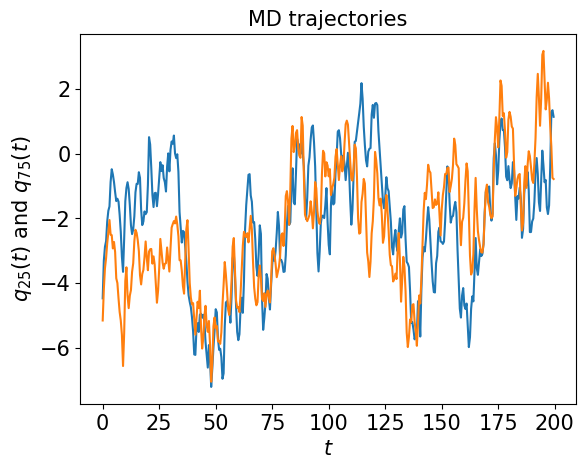

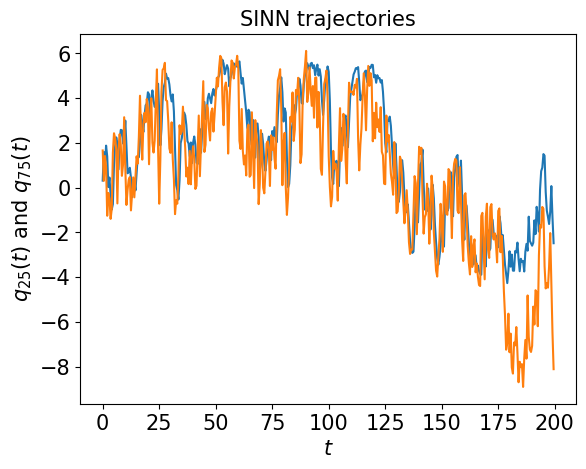

In [34]:
test1(model)

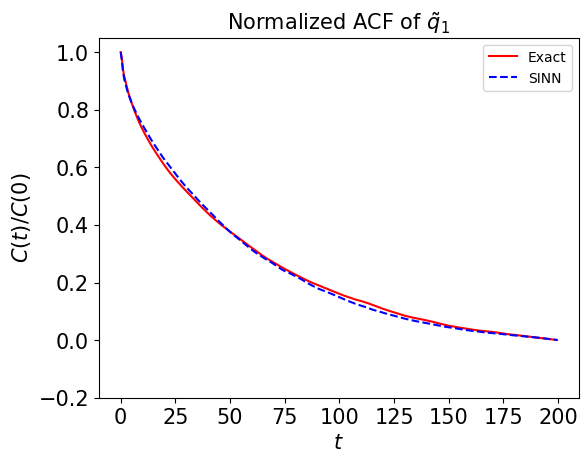

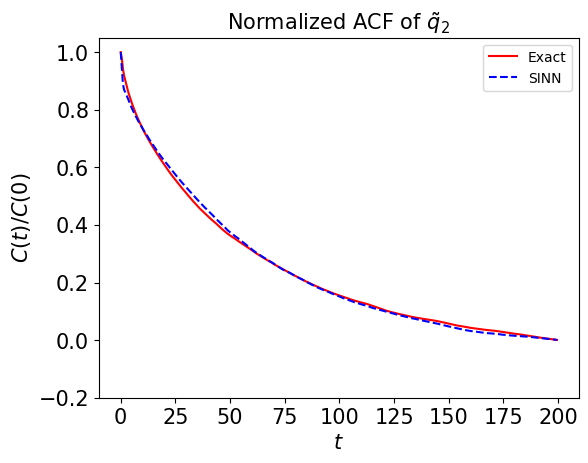

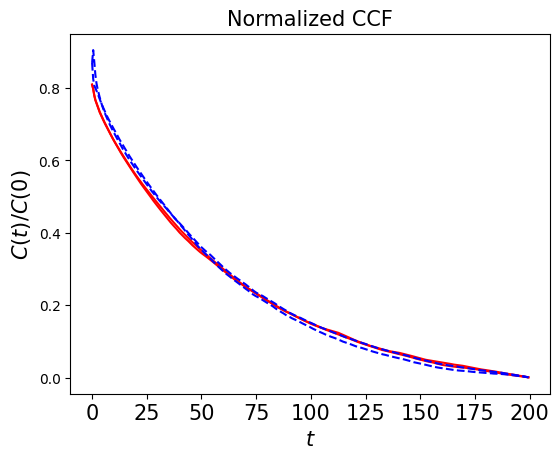

In [35]:
test2(model)

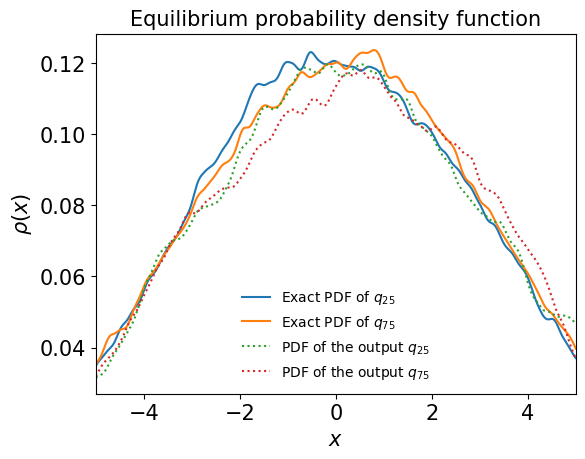

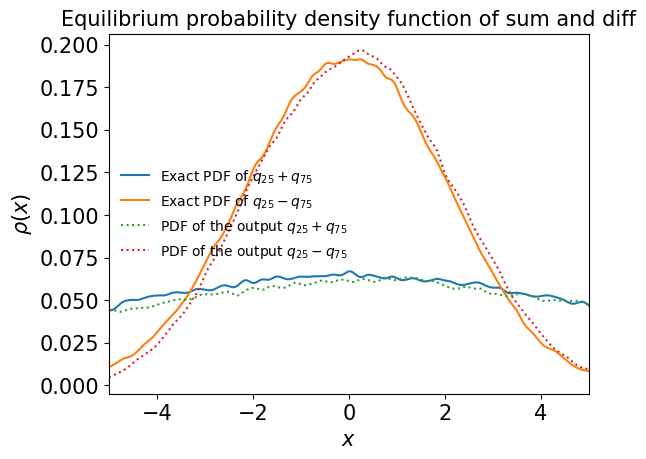

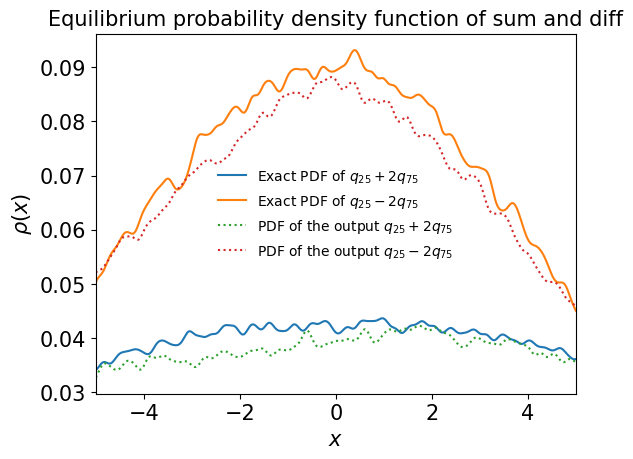

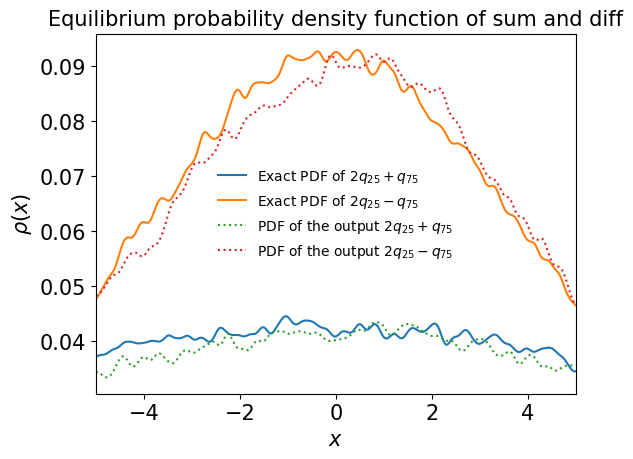

In [36]:
test3(model)

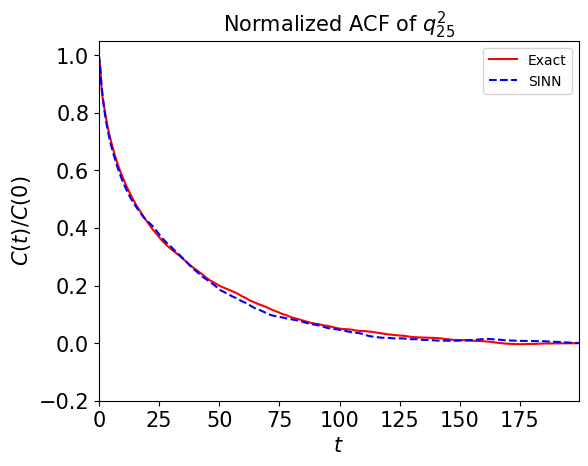

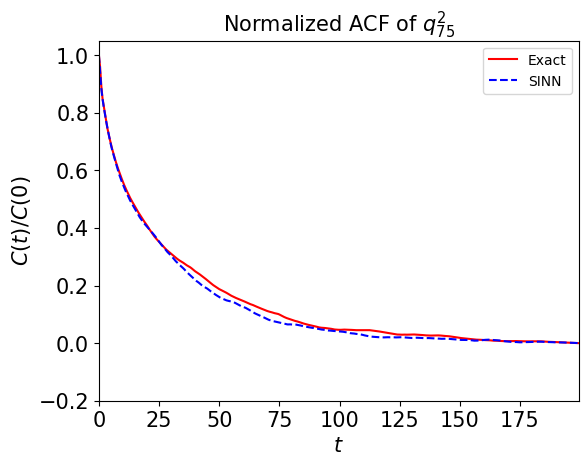

In [37]:
test4(model)

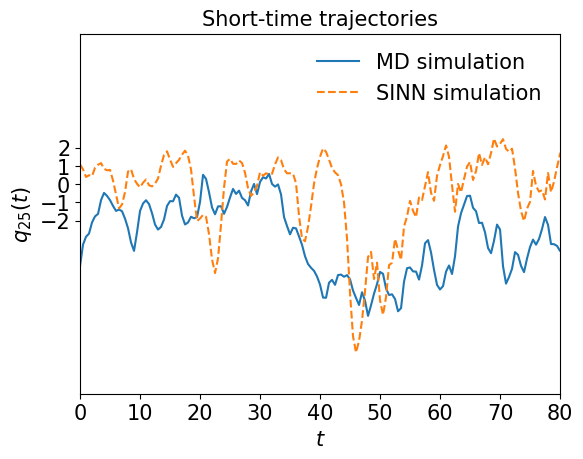

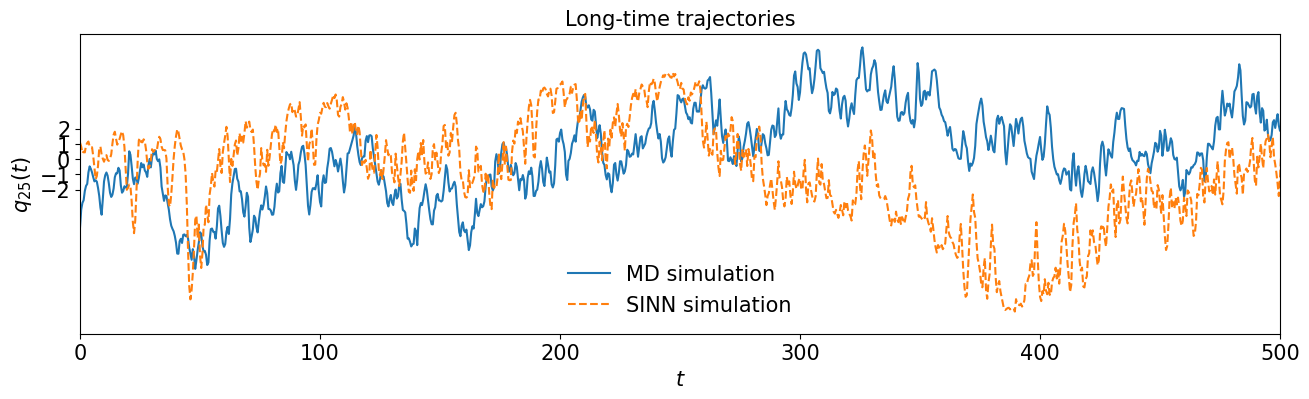

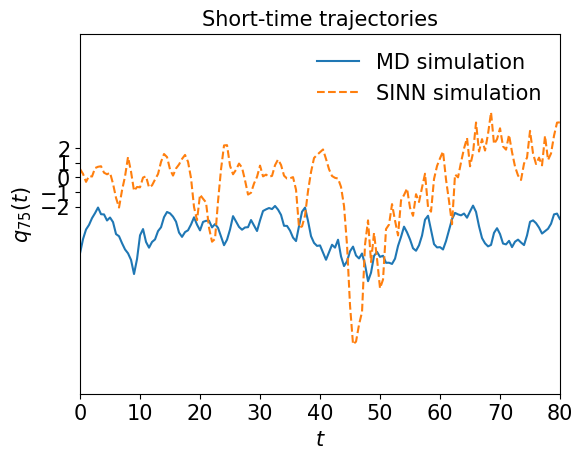

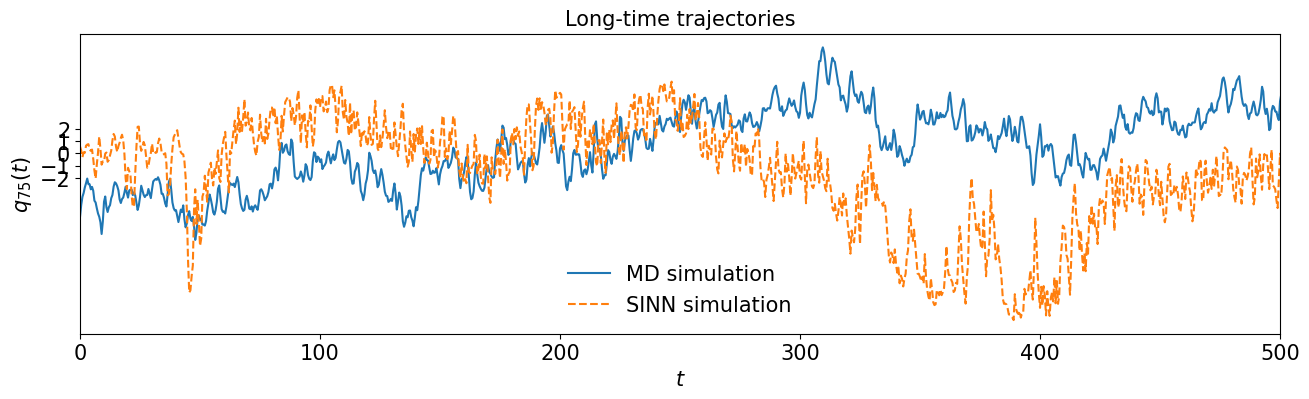

In [38]:
test5(model)

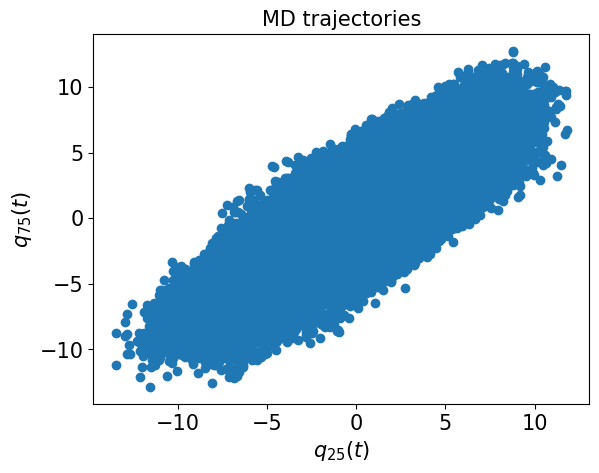

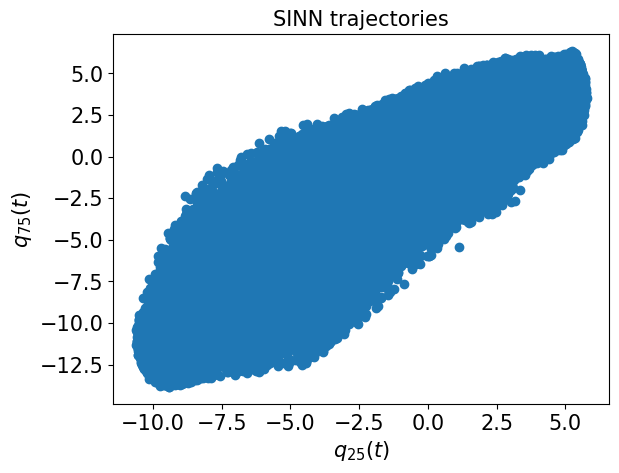

In [39]:
test6(model)

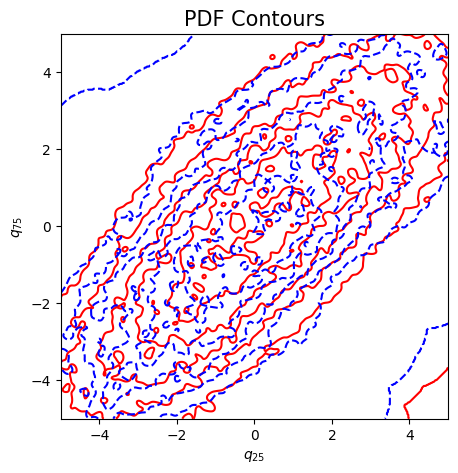

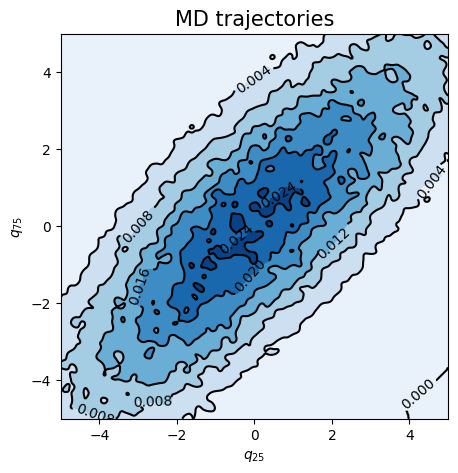

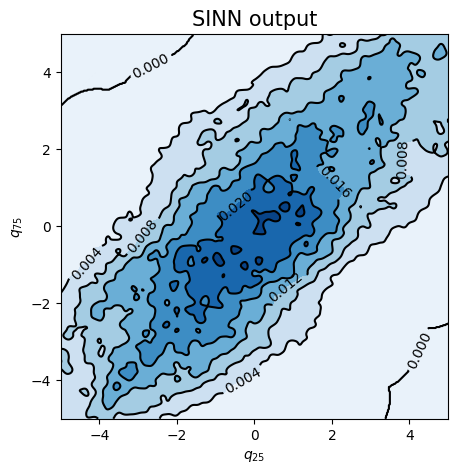

In [40]:
test7(model)

In [41]:
### Defining SINN model
net1 = SINN(2, 50, 2, 2).to(device) # input dimension, hidden size, number of layers, output dimension
model1 = Model(net=net1)
model1.train()

[0]-th step loss: 0.8374, 0.8256, acf: 0.10357, ccf: 0.08893, pdf: 0.29255, pdf2: 0.29328, acf2: 0.04729
[50]-th step loss: 0.0985, 0.0992, acf: 0.01406, ccf: 0.01337, pdf: 0.03397, pdf2: 0.03492, acf2: 0.00287
[100]-th step loss: 0.0992, 0.1035, acf: 0.00250, ccf: 0.00396, pdf: 0.05353, pdf2: 0.03174, acf2: 0.01180
[150]-th step loss: 0.0389, 0.0388, acf: 0.00307, ccf: 0.00352, pdf: 0.00832, pdf2: 0.01757, acf2: 0.00630
[200]-th step loss: 0.0321, 0.0284, acf: 0.00462, ccf: 0.00322, pdf: 0.00750, pdf2: 0.00905, acf2: 0.00405
[250]-th step loss: 0.0232, 0.0256, acf: 0.00062, ccf: 0.00202, pdf: 0.00707, pdf2: 0.00420, acf2: 0.01171
[300]-th step loss: 0.1349, 0.0973, acf: 0.00617, ccf: 0.01137, pdf: 0.00786, pdf2: 0.03620, acf2: 0.03565
[350]-th step loss: 0.1994, 0.1907, acf: 0.07279, ccf: 0.06152, pdf: 0.00833, pdf2: 0.02403, acf2: 0.02403
[400]-th step loss: 0.1499, 0.1291, acf: 0.02136, ccf: 0.02856, pdf: 0.00689, pdf2: 0.01207, acf2: 0.06018
[450]-th step loss: 0.0460, 0.0436, acf:

[3850]-th step loss: 0.0184, 0.0184, acf: 0.00045, ccf: 0.00079, pdf: 0.00465, pdf2: 0.00310, acf2: 0.00939
[3900]-th step loss: 0.0203, 0.0181, acf: 0.00049, ccf: 0.00059, pdf: 0.00603, pdf2: 0.00257, acf2: 0.00845
[3950]-th step loss: 0.0200, 0.0167, acf: 0.00078, ccf: 0.00018, pdf: 0.00648, pdf2: 0.00303, acf2: 0.00623
[4000]-th step loss: 0.0709, 0.0719, acf: 0.00962, ccf: 0.01089, pdf: 0.00832, pdf2: 0.00715, acf2: 0.03596
[4050]-th step loss: 0.1974, 0.1792, acf: 0.07266, ccf: 0.06059, pdf: 0.00833, pdf2: 0.01345, acf2: 0.02418
[4100]-th step loss: 0.0401, 0.0514, acf: 0.01701, ccf: 0.01384, pdf: 0.00833, pdf2: 0.00881, acf2: 0.00344
[4150]-th step loss: 0.0327, 0.0357, acf: 0.00961, ccf: 0.00753, pdf: 0.00833, pdf2: 0.00745, acf2: 0.00276
[4200]-th step loss: 0.0295, 0.0316, acf: 0.00816, ccf: 0.00740, pdf: 0.00833, pdf2: 0.00623, acf2: 0.00153
[4250]-th step loss: 0.0272, 0.0273, acf: 0.00540, ccf: 0.00474, pdf: 0.00833, pdf2: 0.00584, acf2: 0.00301
[4300]-th step loss: 0.0300,

[7650]-th step loss: 0.0117, 0.0119, acf: 0.00216, ccf: 0.00073, pdf: 0.00503, pdf2: 0.00264, acf2: 0.00136
[7700]-th step loss: 0.0111, 0.0116, acf: 0.00138, ccf: 0.00059, pdf: 0.00508, pdf2: 0.00270, acf2: 0.00185
[7750]-th step loss: 0.0127, 0.0112, acf: 0.00176, ccf: 0.00044, pdf: 0.00478, pdf2: 0.00271, acf2: 0.00153
[7800]-th step loss: 0.0115, 0.0109, acf: 0.00121, ccf: 0.00033, pdf: 0.00464, pdf2: 0.00286, acf2: 0.00191
[7850]-th step loss: 0.0112, 0.0113, acf: 0.00208, ccf: 0.00048, pdf: 0.00452, pdf2: 0.00288, acf2: 0.00138
[7900]-th step loss: 0.0128, 0.0111, acf: 0.00113, ccf: 0.00026, pdf: 0.00484, pdf2: 0.00269, acf2: 0.00214
[7950]-th step loss: 0.0119, 0.0116, acf: 0.00186, ccf: 0.00063, pdf: 0.00461, pdf2: 0.00312, acf2: 0.00134
[8000]-th step loss: 0.0113, 0.0110, acf: 0.00088, ccf: 0.00020, pdf: 0.00478, pdf2: 0.00260, acf2: 0.00252
[8050]-th step loss: 0.0111, 0.0109, acf: 0.00075, ccf: 0.00017, pdf: 0.00485, pdf2: 0.00254, acf2: 0.00263
[8100]-th step loss: 0.0124,

[11450]-th step loss: 0.0012, 0.0008, acf: 0.00042, ccf: 0.00017, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00017
[11500]-th step loss: 0.0008, 0.0007, acf: 0.00029, ccf: 0.00022, pdf: 0.00003, pdf2: 0.00001, acf2: 0.00012
[11550]-th step loss: 0.0008, 0.0008, acf: 0.00035, ccf: 0.00009, pdf: 0.00019, pdf2: 0.00005, acf2: 0.00014
[11600]-th step loss: 0.0007, 0.0006, acf: 0.00033, ccf: 0.00014, pdf: 0.00003, pdf2: 0.00001, acf2: 0.00014
[11650]-th step loss: 0.0007, 0.0005, acf: 0.00015, ccf: 0.00019, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00017
[11700]-th step loss: 0.0005, 0.0006, acf: 0.00029, ccf: 0.00010, pdf: 0.00001, pdf2: 0.00000, acf2: 0.00021
[11750]-th step loss: 0.0011, 0.0007, acf: 0.00025, ccf: 0.00009, pdf: 0.00006, pdf2: 0.00002, acf2: 0.00023
[11800]-th step loss: 0.0005, 0.0008, acf: 0.00039, ccf: 0.00013, pdf: 0.00003, pdf2: 0.00001, acf2: 0.00028
[11850]-th step loss: 0.0010, 0.0005, acf: 0.00023, ccf: 0.00006, pdf: 0.00005, pdf2: 0.00002, acf2: 0.00017
[11900]-th step los

In [42]:
### Defining SINN model
net2 = SINN(2, 50, 2, 2).to(device) # input dimension, hidden size, number of layers, output dimension
model2 = Model(net=net2)
model2.train()

[0]-th step loss: 0.8237, 0.8183, acf: 0.10060, ccf: 0.08353, pdf: 0.29326, pdf2: 0.29611, acf2: 0.04482
[50]-th step loss: 0.1268, 0.1157, acf: 0.00957, ccf: 0.00899, pdf: 0.04721, pdf2: 0.04642, acf2: 0.00350
[100]-th step loss: 0.2006, 0.1420, acf: 0.01300, ccf: 0.00907, pdf: 0.05778, pdf2: 0.04704, acf2: 0.01507
[150]-th step loss: 0.1210, 0.1271, acf: 0.00163, ccf: 0.00519, pdf: 0.05085, pdf2: 0.04609, acf2: 0.02337
[200]-th step loss: 0.0269, 0.0233, acf: 0.00037, ccf: 0.00262, pdf: 0.00917, pdf2: 0.00996, acf2: 0.00115
[250]-th step loss: 0.0163, 0.0157, acf: 0.00030, ccf: 0.00157, pdf: 0.00576, pdf2: 0.00704, acf2: 0.00105
[300]-th step loss: 0.0120, 0.0112, acf: 0.00039, ccf: 0.00144, pdf: 0.00325, pdf2: 0.00512, acf2: 0.00103
[350]-th step loss: 0.0090, 0.0098, acf: 0.00089, ccf: 0.00182, pdf: 0.00204, pdf2: 0.00417, acf2: 0.00093
[400]-th step loss: 0.0114, 0.0132, acf: 0.00113, ccf: 0.00306, pdf: 0.00246, pdf2: 0.00418, acf2: 0.00235
[450]-th step loss: 0.0456, 0.0405, acf:

[3850]-th step loss: 0.0040, 0.0031, acf: 0.00134, ccf: 0.00094, pdf: 0.00003, pdf2: 0.00001, acf2: 0.00078
[3900]-th step loss: 0.0034, 0.0057, acf: 0.00136, ccf: 0.00222, pdf: 0.00010, pdf2: 0.00003, acf2: 0.00196
[3950]-th step loss: 0.0028, 0.0032, acf: 0.00158, ccf: 0.00081, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00074
[4000]-th step loss: 0.0027, 0.0033, acf: 0.00093, ccf: 0.00140, pdf: 0.00008, pdf2: 0.00002, acf2: 0.00087
[4050]-th step loss: 0.0029, 0.0041, acf: 0.00107, ccf: 0.00164, pdf: 0.00007, pdf2: 0.00001, acf2: 0.00133
[4100]-th step loss: 0.0298, 0.0291, acf: 0.01109, ccf: 0.00674, pdf: 0.00041, pdf2: 0.00034, acf2: 0.01054
[4150]-th step loss: 0.0240, 0.0222, acf: 0.00862, ccf: 0.00598, pdf: 0.00030, pdf2: 0.00017, acf2: 0.00710
[4200]-th step loss: 0.0192, 0.0174, acf: 0.00729, ccf: 0.00512, pdf: 0.00028, pdf2: 0.00008, acf2: 0.00466
[4250]-th step loss: 0.0152, 0.0143, acf: 0.00613, ccf: 0.00439, pdf: 0.00025, pdf2: 0.00005, acf2: 0.00349
[4300]-th step loss: 0.0114,

In [43]:
### Defining SINN model
net3 = SINN(2, 50, 2, 2).to(device) # input dimension, hidden size, number of layers, output dimension
model3 = Model(net=net3)
model3.train()

[0]-th step loss: 0.8488, 0.8425, acf: 0.10258, ccf: 0.10609, pdf: 0.29288, pdf2: 0.29451, acf2: 0.04642
[50]-th step loss: 0.1244, 0.1354, acf: 0.00289, ccf: 0.00516, pdf: 0.08660, pdf2: 0.03918, acf2: 0.00156
[100]-th step loss: 0.0727, 0.0750, acf: 0.00134, ccf: 0.00370, pdf: 0.03671, pdf2: 0.01660, acf2: 0.01664
[150]-th step loss: 0.0424, 0.0456, acf: 0.00503, ccf: 0.00545, pdf: 0.01985, pdf2: 0.00898, acf2: 0.00626
[200]-th step loss: 0.0463, 0.0460, acf: 0.00583, ccf: 0.00591, pdf: 0.01913, pdf2: 0.00846, acf2: 0.00668
[250]-th step loss: 0.0343, 0.0312, acf: 0.00568, ccf: 0.00573, pdf: 0.01166, pdf2: 0.00575, acf2: 0.00235
[300]-th step loss: 0.2284, 0.2282, acf: 0.07472, ccf: 0.06249, pdf: 0.04144, pdf2: 0.02307, acf2: 0.02653
[350]-th step loss: 0.1185, 0.1161, acf: 0.04639, ccf: 0.03902, pdf: 0.01320, pdf2: 0.00646, acf2: 0.01103
[400]-th step loss: 0.0153, 0.0157, acf: 0.00202, ccf: 0.00279, pdf: 0.00533, pdf2: 0.00439, acf2: 0.00115
[450]-th step loss: 0.0118, 0.0126, acf:

[3850]-th step loss: 0.1720, 0.1718, acf: 0.00004, ccf: 0.00012, pdf: 0.15086, pdf2: 0.00534, acf2: 0.01548
[3900]-th step loss: 0.1688, 0.1675, acf: 0.00034, ccf: 0.00043, pdf: 0.15088, pdf2: 0.00534, acf2: 0.01047
[3950]-th step loss: 0.1692, 0.1730, acf: 0.00010, ccf: 0.00027, pdf: 0.15086, pdf2: 0.00534, acf2: 0.01646
[4000]-th step loss: 0.1674, 0.1687, acf: 0.00012, ccf: 0.00009, pdf: 0.15087, pdf2: 0.00534, acf2: 0.01228
[4050]-th step loss: 0.1671, 0.1684, acf: 0.00015, ccf: 0.00012, pdf: 0.15087, pdf2: 0.00534, acf2: 0.01191
[4100]-th step loss: 0.1673, 0.1669, acf: 0.00044, ccf: 0.00026, pdf: 0.15088, pdf2: 0.00534, acf2: 0.01004
[4150]-th step loss: 0.1693, 0.1698, acf: 0.00004, ccf: 0.00003, pdf: 0.15087, pdf2: 0.00534, acf2: 0.01352
[4200]-th step loss: 0.1699, 0.1702, acf: 0.00004, ccf: 0.00005, pdf: 0.15086, pdf2: 0.00534, acf2: 0.01392
[4250]-th step loss: 0.1687, 0.1709, acf: 0.00002, ccf: 0.00005, pdf: 0.15087, pdf2: 0.00534, acf2: 0.01465
[4300]-th step loss: 0.1684,

[7650]-th step loss: 0.0011, 0.0012, acf: 0.00030, ccf: 0.00069, pdf: 0.00005, pdf2: 0.00001, acf2: 0.00015
[7700]-th step loss: 0.0022, 0.0012, acf: 0.00014, ccf: 0.00075, pdf: 0.00010, pdf2: 0.00004, acf2: 0.00016
[7750]-th step loss: 0.0014, 0.0011, acf: 0.00018, ccf: 0.00069, pdf: 0.00005, pdf2: 0.00002, acf2: 0.00012
[7800]-th step loss: 0.0026, 0.0015, acf: 0.00058, ccf: 0.00047, pdf: 0.00007, pdf2: 0.00001, acf2: 0.00039
[7850]-th step loss: 0.0012, 0.0011, acf: 0.00031, ccf: 0.00052, pdf: 0.00005, pdf2: 0.00001, acf2: 0.00019
[7900]-th step loss: 0.0012, 0.0012, acf: 0.00039, ccf: 0.00052, pdf: 0.00007, pdf2: 0.00002, acf2: 0.00019
[7950]-th step loss: 0.0014, 0.0023, acf: 0.00033, ccf: 0.00130, pdf: 0.00010, pdf2: 0.00003, acf2: 0.00056
[8000]-th step loss: 0.0026, 0.0022, acf: 0.00039, ccf: 0.00139, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00043
[8050]-th step loss: 0.0014, 0.0019, acf: 0.00037, ccf: 0.00117, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00037
[8100]-th step loss: 0.0012,

[11450]-th step loss: 0.0007, 0.0009, acf: 0.00035, ccf: 0.00026, pdf: 0.00003, pdf2: 0.00001, acf2: 0.00022
[11500]-th step loss: 0.0010, 0.0012, acf: 0.00091, ccf: 0.00016, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00011
[11550]-th step loss: 0.0011, 0.0009, acf: 0.00060, ccf: 0.00014, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00012
[11600]-th step loss: 0.0018, 0.0007, acf: 0.00035, ccf: 0.00022, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00010
[11650]-th step loss: 0.0008, 0.0010, acf: 0.00036, ccf: 0.00020, pdf: 0.00004, pdf2: 0.00001, acf2: 0.00043
[11700]-th step loss: 0.0006, 0.0008, acf: 0.00060, ccf: 0.00011, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00009
[11750]-th step loss: 0.0022, 0.0020, acf: 0.00043, ccf: 0.00131, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00022
[11800]-th step loss: 0.0029, 0.0009, acf: 0.00049, ccf: 0.00013, pdf: 0.00004, pdf2: 0.00001, acf2: 0.00026
[11850]-th step loss: 0.0007, 0.0008, acf: 0.00043, ccf: 0.00012, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00018
[11900]-th step los

In [44]:
### Defining SINN model
net4 = SINN(2, 50, 2, 2).to(device) # input dimension, hidden size, number of layers, output dimension
model4 = Model(net=net4)
model4.train()

[0]-th step loss: 0.8368, 0.8212, acf: 0.10158, ccf: 0.08479, pdf: 0.29330, pdf2: 0.29594, acf2: 0.04560
[50]-th step loss: 0.3713, 0.3754, acf: 0.00256, ccf: 0.00579, pdf: 0.20091, pdf2: 0.15983, acf2: 0.00635
[100]-th step loss: 0.1219, 0.1320, acf: 0.01625, ccf: 0.02125, pdf: 0.04218, pdf2: 0.04675, acf2: 0.00560
[150]-th step loss: 0.0667, 0.0673, acf: 0.00450, ccf: 0.02219, pdf: 0.01670, pdf2: 0.01892, acf2: 0.00499
[200]-th step loss: 0.0478, 0.0452, acf: 0.00302, ccf: 0.01454, pdf: 0.01113, pdf2: 0.01249, acf2: 0.00397
[250]-th step loss: 0.0137, 0.0141, acf: 0.00064, ccf: 0.00304, pdf: 0.00522, pdf2: 0.00408, acf2: 0.00111
[300]-th step loss: 0.3178, 0.2885, acf: 0.06771, ccf: 0.05903, pdf: 0.07710, pdf2: 0.06318, acf2: 0.02148
[350]-th step loss: 0.1162, 0.1278, acf: 0.03537, ccf: 0.02991, pdf: 0.02033, pdf2: 0.02731, acf2: 0.01486
[400]-th step loss: 0.0508, 0.0520, acf: 0.00306, ccf: 0.00425, pdf: 0.01857, pdf2: 0.02196, acf2: 0.00416
[450]-th step loss: 0.0231, 0.0244, acf:

[3850]-th step loss: 0.0114, 0.0111, acf: 0.00085, ccf: 0.00004, pdf: 0.00454, pdf2: 0.00288, acf2: 0.00280
[3900]-th step loss: 0.0121, 0.0117, acf: 0.00058, ccf: 0.00003, pdf: 0.00437, pdf2: 0.00317, acf2: 0.00351
[3950]-th step loss: 0.0124, 0.0125, acf: 0.00033, ccf: 0.00017, pdf: 0.00442, pdf2: 0.00305, acf2: 0.00455
[4000]-th step loss: 0.0113, 0.0113, acf: 0.00055, ccf: 0.00005, pdf: 0.00461, pdf2: 0.00280, acf2: 0.00329
[4050]-th step loss: 0.0111, 0.0108, acf: 0.00134, ccf: 0.00020, pdf: 0.00465, pdf2: 0.00269, acf2: 0.00189
[4100]-th step loss: 0.0111, 0.0109, acf: 0.00146, ccf: 0.00030, pdf: 0.00480, pdf2: 0.00262, acf2: 0.00172
[4150]-th step loss: 0.0107, 0.0107, acf: 0.00079, ccf: 0.00005, pdf: 0.00492, pdf2: 0.00258, acf2: 0.00237
[4200]-th step loss: 0.0129, 0.0133, acf: 0.00039, ccf: 0.00024, pdf: 0.00435, pdf2: 0.00333, acf2: 0.00496
[4250]-th step loss: 0.0116, 0.0114, acf: 0.00065, ccf: 0.00005, pdf: 0.00455, pdf2: 0.00285, acf2: 0.00330
[4300]-th step loss: 0.0107,

[7650]-th step loss: 0.0012, 0.0011, acf: 0.00059, ccf: 0.00021, pdf: 0.00009, pdf2: 0.00003, acf2: 0.00022
[7700]-th step loss: 0.0011, 0.0012, acf: 0.00042, ccf: 0.00025, pdf: 0.00014, pdf2: 0.00005, acf2: 0.00035
[7750]-th step loss: 0.0009, 0.0006, acf: 0.00024, ccf: 0.00008, pdf: 0.00006, pdf2: 0.00001, acf2: 0.00022
[7800]-th step loss: 0.0015, 0.0007, acf: 0.00017, ccf: 0.00013, pdf: 0.00010, pdf2: 0.00002, acf2: 0.00026
[7850]-th step loss: 0.0014, 0.0005, acf: 0.00012, ccf: 0.00008, pdf: 0.00010, pdf2: 0.00003, acf2: 0.00015
[7900]-th step loss: 0.0013, 0.0011, acf: 0.00022, ccf: 0.00007, pdf: 0.00009, pdf2: 0.00002, acf2: 0.00066
[7950]-th step loss: 0.0008, 0.0009, acf: 0.00027, ccf: 0.00014, pdf: 0.00017, pdf2: 0.00013, acf2: 0.00021
[8000]-th step loss: 0.0009, 0.0018, acf: 0.00017, ccf: 0.00025, pdf: 0.00018, pdf2: 0.00018, acf2: 0.00097
[8050]-th step loss: 0.0005, 0.0005, acf: 0.00019, ccf: 0.00006, pdf: 0.00004, pdf2: 0.00002, acf2: 0.00021
[8100]-th step loss: 0.0010,

In [45]:
### Defining SINN model
net5 = SINN(2, 50, 2, 2).to(device) # input dimension, hidden size, number of layers, output dimension
model5 = Model(net=net5)
model5.train()

[0]-th step loss: 0.8447, 0.8315, acf: 0.10305, ccf: 0.09301, pdf: 0.29314, pdf2: 0.29550, acf2: 0.04681
[50]-th step loss: 0.3318, 0.3439, acf: 0.02449, ccf: 0.02165, pdf: 0.16023, pdf2: 0.12095, acf2: 0.01655
[100]-th step loss: 0.0329, 0.0315, acf: 0.00093, ccf: 0.00382, pdf: 0.01117, pdf2: 0.01390, acf2: 0.00165
[150]-th step loss: 0.0221, 0.0186, acf: 0.00109, ccf: 0.00211, pdf: 0.00605, pdf2: 0.00779, acf2: 0.00160
[200]-th step loss: 0.0169, 0.0171, acf: 0.00130, ccf: 0.00222, pdf: 0.00532, pdf2: 0.00652, acf2: 0.00177
[250]-th step loss: 0.1490, 0.1350, acf: 0.01000, ccf: 0.00968, pdf: 0.06274, pdf2: 0.05024, acf2: 0.00233
[300]-th step loss: 0.0365, 0.0405, acf: 0.01468, ccf: 0.01306, pdf: 0.00442, pdf2: 0.00617, acf2: 0.00216
[350]-th step loss: 0.0133, 0.0138, acf: 0.00129, ccf: 0.00309, pdf: 0.00147, pdf2: 0.00435, acf2: 0.00361
[400]-th step loss: 0.0084, 0.0147, acf: 0.00059, ccf: 0.00304, pdf: 0.00176, pdf2: 0.00408, acf2: 0.00526
[450]-th step loss: 0.0074, 0.0083, acf:

[3850]-th step loss: 0.0783, 0.0861, acf: 0.01585, ccf: 0.01144, pdf: 0.00833, pdf2: 0.05033, acf2: 0.00010
[3900]-th step loss: 0.0786, 0.0859, acf: 0.01578, ccf: 0.01134, pdf: 0.00833, pdf2: 0.05035, acf2: 0.00011
[3950]-th step loss: 0.0842, 0.0833, acf: 0.01434, ccf: 0.01023, pdf: 0.00833, pdf2: 0.05036, acf2: 0.00009
[4000]-th step loss: 0.0844, 0.0854, acf: 0.01542, ccf: 0.01116, pdf: 0.00833, pdf2: 0.05037, acf2: 0.00012
[4050]-th step loss: 0.0815, 0.0873, acf: 0.01647, ccf: 0.01195, pdf: 0.00833, pdf2: 0.05038, acf2: 0.00016
[4100]-th step loss: 0.0812, 0.0912, acf: 0.01865, ccf: 0.01357, pdf: 0.00833, pdf2: 0.05035, acf2: 0.00035
[4150]-th step loss: 0.0779, 0.0828, acf: 0.01406, ccf: 0.00995, pdf: 0.00833, pdf2: 0.05036, acf2: 0.00009
[4200]-th step loss: 0.0791, 0.0854, acf: 0.01557, ccf: 0.01102, pdf: 0.00833, pdf2: 0.05036, acf2: 0.00011
[4250]-th step loss: 0.0860, 0.0915, acf: 0.01874, ccf: 0.01376, pdf: 0.00833, pdf2: 0.05036, acf2: 0.00036
[4300]-th step loss: 0.0792,

[7650]-th step loss: 0.0829, 0.0884, acf: 0.01717, ccf: 0.01232, pdf: 0.00833, pdf2: 0.05038, acf2: 0.00019
[7700]-th step loss: 0.0774, 0.0850, acf: 0.01520, ccf: 0.01101, pdf: 0.00833, pdf2: 0.05037, acf2: 0.00010
[7750]-th step loss: 0.0803, 0.0863, acf: 0.01599, ccf: 0.01153, pdf: 0.00833, pdf2: 0.05038, acf2: 0.00011
[7800]-th step loss: 0.0812, 0.0861, acf: 0.01577, ccf: 0.01147, pdf: 0.00833, pdf2: 0.05037, acf2: 0.00012
[7850]-th step loss: 0.0864, 0.0886, acf: 0.01717, ccf: 0.01255, pdf: 0.00833, pdf2: 0.05036, acf2: 0.00018
[7900]-th step loss: 0.0865, 0.0861, acf: 0.01598, ccf: 0.01129, pdf: 0.00833, pdf2: 0.05038, acf2: 0.00011
[7950]-th step loss: 0.0890, 0.0859, acf: 0.01578, ccf: 0.01136, pdf: 0.00833, pdf2: 0.05037, acf2: 0.00010
[8000]-th step loss: 0.0906, 0.0884, acf: 0.01714, ccf: 0.01238, pdf: 0.00833, pdf2: 0.05037, acf2: 0.00018
[8050]-th step loss: 0.0772, 0.0852, acf: 0.01532, ccf: 0.01110, pdf: 0.00833, pdf2: 0.05035, acf2: 0.00009
[8100]-th step loss: 0.0935,

[11450]-th step loss: 0.0783, 0.0866, acf: 0.01618, ccf: 0.01164, pdf: 0.00833, pdf2: 0.05034, acf2: 0.00012
[11500]-th step loss: 0.0816, 0.0878, acf: 0.01677, ccf: 0.01213, pdf: 0.00833, pdf2: 0.05037, acf2: 0.00018
[11550]-th step loss: 0.0828, 0.0937, acf: 0.01971, ccf: 0.01478, pdf: 0.00833, pdf2: 0.05039, acf2: 0.00053
[11600]-th step loss: 0.0835, 0.0896, acf: 0.01767, ccf: 0.01296, pdf: 0.00833, pdf2: 0.05036, acf2: 0.00025
[11650]-th step loss: 0.0787, 0.0870, acf: 0.01636, ccf: 0.01179, pdf: 0.00833, pdf2: 0.05040, acf2: 0.00017
[11700]-th step loss: 0.0849, 0.0893, acf: 0.01754, ccf: 0.01275, pdf: 0.00833, pdf2: 0.05041, acf2: 0.00028
[11750]-th step loss: 0.0767, 0.0842, acf: 0.01490, ccf: 0.01048, pdf: 0.00833, pdf2: 0.05038, acf2: 0.00011
[11800]-th step loss: 0.0816, 0.0857, acf: 0.01561, ccf: 0.01122, pdf: 0.00833, pdf2: 0.05038, acf2: 0.00012
[11850]-th step loss: 0.0858, 0.0878, acf: 0.01684, ccf: 0.01208, pdf: 0.00833, pdf2: 0.05036, acf2: 0.00017
[11900]-th step los

[15250]-th step loss: 0.0765, 0.0853, acf: 0.01546, ccf: 0.01104, pdf: 0.00832, pdf2: 0.05034, acf2: 0.00012
[15300]-th step loss: 0.0838, 0.0883, acf: 0.01708, ccf: 0.01223, pdf: 0.00833, pdf2: 0.05042, acf2: 0.00025
[15350]-th step loss: 0.0795, 0.0898, acf: 0.01783, ccf: 0.01299, pdf: 0.00833, pdf2: 0.05036, acf2: 0.00029
[15400]-th step loss: 0.0755, 0.0862, acf: 0.01590, ccf: 0.01146, pdf: 0.00833, pdf2: 0.05037, acf2: 0.00017
[15450]-th step loss: 0.0813, 0.0861, acf: 0.01588, ccf: 0.01133, pdf: 0.00833, pdf2: 0.05038, acf2: 0.00015
[15500]-th step loss: 0.0921, 0.0906, acf: 0.01827, ccf: 0.01327, pdf: 0.00833, pdf2: 0.05037, acf2: 0.00034
[15550]-th step loss: 0.0836, 0.0887, acf: 0.01728, ccf: 0.01250, pdf: 0.00833, pdf2: 0.05038, acf2: 0.00023
[15600]-th step loss: 0.0809, 0.0884, acf: 0.01696, ccf: 0.01247, pdf: 0.00833, pdf2: 0.05039, acf2: 0.00027
[15650]-th step loss: 0.0804, 0.0883, acf: 0.01703, ccf: 0.01231, pdf: 0.00833, pdf2: 0.05037, acf2: 0.00021
[15700]-th step los

[19050]-th step loss: 0.0853, 0.0865, acf: 0.01616, ccf: 0.01157, pdf: 0.00832, pdf2: 0.05035, acf2: 0.00011
[19100]-th step loss: 0.0826, 0.0837, acf: 0.01449, ccf: 0.01039, pdf: 0.00833, pdf2: 0.05038, acf2: 0.00008
[19150]-th step loss: 0.0777, 0.0872, acf: 0.01645, ccf: 0.01192, pdf: 0.00833, pdf2: 0.05033, acf2: 0.00014
[19200]-th step loss: 0.0887, 0.0865, acf: 0.01612, ccf: 0.01158, pdf: 0.00832, pdf2: 0.05034, acf2: 0.00012
[19250]-th step loss: 0.0870, 0.0883, acf: 0.01707, ccf: 0.01241, pdf: 0.00832, pdf2: 0.05033, acf2: 0.00018
[19300]-th step loss: 0.0837, 0.0838, acf: 0.01467, ccf: 0.01036, pdf: 0.00832, pdf2: 0.05035, acf2: 0.00007
[19350]-th step loss: 0.0858, 0.0879, acf: 0.01680, ccf: 0.01224, pdf: 0.00833, pdf2: 0.05034, acf2: 0.00017
[19400]-th step loss: 0.0821, 0.0854, acf: 0.01553, ccf: 0.01112, pdf: 0.00833, pdf2: 0.05035, acf2: 0.00009
[19450]-th step loss: 0.0788, 0.0870, acf: 0.01651, ccf: 0.01165, pdf: 0.00833, pdf2: 0.05037, acf2: 0.00017
[19500]-th step los

In [46]:
### Defining SINN model
net6 = SINN(2, 50, 2, 2).to(device) # input dimension, hidden size, number of layers, output dimension
model6 = Model(net=net6)
model6.train()

[0]-th step loss: 0.8486, 0.8427, acf: 0.10259, ccf: 0.10592, pdf: 0.29299, pdf2: 0.29477, acf2: 0.04645
[50]-th step loss: 0.1667, 0.1763, acf: 0.00746, ccf: 0.00754, pdf: 0.08232, pdf2: 0.07668, acf2: 0.00230
[100]-th step loss: 0.0302, 0.0302, acf: 0.00195, ccf: 0.00312, pdf: 0.00966, pdf2: 0.01398, acf2: 0.00146
[150]-th step loss: 0.0366, 0.0393, acf: 0.00247, ccf: 0.00159, pdf: 0.01354, pdf2: 0.01385, acf2: 0.00784
[200]-th step loss: 0.0649, 0.0826, acf: 0.03011, ccf: 0.02469, pdf: 0.00839, pdf2: 0.01062, acf2: 0.00884
[250]-th step loss: 0.0271, 0.0241, acf: 0.00408, ccf: 0.00403, pdf: 0.00524, pdf2: 0.00763, acf2: 0.00310
[300]-th step loss: 0.0092, 0.0090, acf: 0.00036, ccf: 0.00139, pdf: 0.00168, pdf2: 0.00430, acf2: 0.00123
[350]-th step loss: 0.0083, 0.0077, acf: 0.00037, ccf: 0.00152, pdf: 0.00123, pdf2: 0.00361, acf2: 0.00097
[400]-th step loss: 0.0072, 0.0071, acf: 0.00043, ccf: 0.00196, pdf: 0.00084, pdf2: 0.00313, acf2: 0.00073
[450]-th step loss: 0.0125, 0.0113, acf:

[3850]-th step loss: 0.0133, 0.0131, acf: 0.00003, ccf: 0.00007, pdf: 0.00569, pdf2: 0.00209, acf2: 0.00525
[3900]-th step loss: 0.0136, 0.0133, acf: 0.00002, ccf: 0.00011, pdf: 0.00591, pdf2: 0.00213, acf2: 0.00512
[3950]-th step loss: 0.0137, 0.0132, acf: 0.00003, ccf: 0.00012, pdf: 0.00572, pdf2: 0.00211, acf2: 0.00519
[4000]-th step loss: 0.0137, 0.0151, acf: 0.00031, ccf: 0.00049, pdf: 0.00560, pdf2: 0.00213, acf2: 0.00661
[4050]-th step loss: 0.0129, 0.0127, acf: 0.00004, ccf: 0.00007, pdf: 0.00599, pdf2: 0.00213, acf2: 0.00445
[4100]-th step loss: 0.0122, 0.0135, acf: 0.00006, ccf: 0.00018, pdf: 0.00550, pdf2: 0.00215, acf2: 0.00564
[4150]-th step loss: 0.0140, 0.0144, acf: 0.00017, ccf: 0.00022, pdf: 0.00529, pdf2: 0.00224, acf2: 0.00647
[4200]-th step loss: 0.0132, 0.0134, acf: 0.00006, ccf: 0.00016, pdf: 0.00541, pdf2: 0.00218, acf2: 0.00558
[4250]-th step loss: 0.0150, 0.0155, acf: 0.00023, ccf: 0.00020, pdf: 0.00589, pdf2: 0.00228, acf2: 0.00692
[4300]-th step loss: 0.0118,

[7650]-th step loss: 0.0141, 0.0133, acf: 0.00018, ccf: 0.00005, pdf: 0.00526, pdf2: 0.00227, acf2: 0.00558
[7700]-th step loss: 0.0105, 0.0104, acf: 0.00005, ccf: 0.00003, pdf: 0.00536, pdf2: 0.00219, acf2: 0.00274
[7750]-th step loss: 0.0101, 0.0103, acf: 0.00007, ccf: 0.00002, pdf: 0.00557, pdf2: 0.00214, acf2: 0.00253
[7800]-th step loss: 0.0099, 0.0110, acf: 0.00002, ccf: 0.00010, pdf: 0.00539, pdf2: 0.00218, acf2: 0.00328
[7850]-th step loss: 0.0118, 0.0111, acf: 0.00005, ccf: 0.00015, pdf: 0.00530, pdf2: 0.00225, acf2: 0.00337
[7900]-th step loss: 0.0106, 0.0104, acf: 0.00004, ccf: 0.00003, pdf: 0.00545, pdf2: 0.00217, acf2: 0.00270
[7950]-th step loss: 0.0127, 0.0107, acf: 0.00001, ccf: 0.00005, pdf: 0.00518, pdf2: 0.00224, acf2: 0.00322
[8000]-th step loss: 0.0128, 0.0116, acf: 0.00007, ccf: 0.00004, pdf: 0.00615, pdf2: 0.00224, acf2: 0.00305
[8050]-th step loss: 0.0104, 0.0103, acf: 0.00002, ccf: 0.00004, pdf: 0.00534, pdf2: 0.00220, acf2: 0.00270
[8100]-th step loss: 0.0104,

[11450]-th step loss: 0.0006, 0.0006, acf: 0.00013, ccf: 0.00014, pdf: 0.00023, pdf2: 0.00006, acf2: 0.00008
[11500]-th step loss: 0.0009, 0.0005, acf: 0.00004, ccf: 0.00008, pdf: 0.00019, pdf2: 0.00005, acf2: 0.00010
[11550]-th step loss: 0.0009, 0.0003, acf: 0.00005, ccf: 0.00003, pdf: 0.00015, pdf2: 0.00002, acf2: 0.00009
[11600]-th step loss: 0.0004, 0.0007, acf: 0.00018, ccf: 0.00018, pdf: 0.00016, pdf2: 0.00003, acf2: 0.00018
[11650]-th step loss: 0.0005, 0.0004, acf: 0.00008, ccf: 0.00004, pdf: 0.00017, pdf2: 0.00002, acf2: 0.00011
[11700]-th step loss: 0.0013, 0.0008, acf: 0.00016, ccf: 0.00018, pdf: 0.00017, pdf2: 0.00003, acf2: 0.00024
[11750]-th step loss: 0.0004, 0.0006, acf: 0.00012, ccf: 0.00009, pdf: 0.00023, pdf2: 0.00003, acf2: 0.00015
[11800]-th step loss: 0.0005, 0.0005, acf: 0.00012, ccf: 0.00008, pdf: 0.00019, pdf2: 0.00004, acf2: 0.00011
[11850]-th step loss: 0.0011, 0.0010, acf: 0.00030, ccf: 0.00031, pdf: 0.00017, pdf2: 0.00002, acf2: 0.00021
[11900]-th step los

In [47]:
### Defining SINN model
net7 = SINN(2, 50, 2, 2).to(device) # input dimension, hidden size, number of layers, output dimension
model7 = Model(net=net7)
model7.train()

[0]-th step loss: 0.8283, 0.8225, acf: 0.10270, ccf: 0.08525, pdf: 0.29299, pdf2: 0.29500, acf2: 0.04655
[50]-th step loss: 0.1477, 0.1601, acf: 0.01716, ccf: 0.01378, pdf: 0.05584, pdf2: 0.06130, acf2: 0.01200
[100]-th step loss: 0.0636, 0.0691, acf: 0.00772, ccf: 0.00744, pdf: 0.02437, pdf2: 0.02576, acf2: 0.00386
[150]-th step loss: 0.0316, 0.0312, acf: 0.00226, ccf: 0.00323, pdf: 0.01056, pdf2: 0.01333, acf2: 0.00180
[200]-th step loss: 0.0273, 0.0256, acf: 0.00268, ccf: 0.00197, pdf: 0.00796, pdf2: 0.01101, acf2: 0.00197
[250]-th step loss: 0.0151, 0.0178, acf: 0.00357, ccf: 0.00130, pdf: 0.00414, pdf2: 0.00714, acf2: 0.00166
[300]-th step loss: 0.0172, 0.0212, acf: 0.00221, ccf: 0.00270, pdf: 0.00569, pdf2: 0.00927, acf2: 0.00131
[350]-th step loss: 0.0209, 0.0149, acf: 0.00232, ccf: 0.00240, pdf: 0.00337, pdf2: 0.00575, acf2: 0.00108
[400]-th step loss: 0.0112, 0.0213, acf: 0.00556, ccf: 0.00186, pdf: 0.00560, pdf2: 0.00725, acf2: 0.00098
[450]-th step loss: 0.0166, 0.0243, acf:

In [48]:
### Defining SINN model
net8 = SINN(2, 50, 2, 2).to(device) # input dimension, hidden size, number of layers, output dimension
model8 = Model(net=net8)
model8.train()

[0]-th step loss: 0.8461, 0.8279, acf: 0.10189, ccf: 0.09084, pdf: 0.29333, pdf2: 0.29602, acf2: 0.04577
[50]-th step loss: 0.1561, 0.1615, acf: 0.00475, ccf: 0.00602, pdf: 0.07306, pdf2: 0.06800, acf2: 0.00962
[100]-th step loss: 0.1276, 0.1202, acf: 0.04372, ccf: 0.03753, pdf: 0.01349, pdf2: 0.01399, acf2: 0.01151
[150]-th step loss: 0.0329, 0.0330, acf: 0.00492, ccf: 0.00576, pdf: 0.00800, pdf2: 0.01191, acf2: 0.00243
[200]-th step loss: 0.0199, 0.0207, acf: 0.00206, ccf: 0.00381, pdf: 0.00463, pdf2: 0.00820, acf2: 0.00201
[250]-th step loss: 0.0357, 0.0244, acf: 0.00065, ccf: 0.00316, pdf: 0.00888, pdf2: 0.01022, acf2: 0.00147
[300]-th step loss: 0.0146, 0.0124, acf: 0.00091, ccf: 0.00346, pdf: 0.00249, pdf2: 0.00470, acf2: 0.00083
[350]-th step loss: 0.0106, 0.0128, acf: 0.00064, ccf: 0.00314, pdf: 0.00305, pdf2: 0.00484, acf2: 0.00111
[400]-th step loss: 0.0086, 0.0095, acf: 0.00064, ccf: 0.00259, pdf: 0.00142, pdf2: 0.00384, acf2: 0.00098
[450]-th step loss: 0.0085, 0.0082, acf:

[3850]-th step loss: 0.0117, 0.0130, acf: 0.00002, ccf: 0.00007, pdf: 0.00511, pdf2: 0.00219, acf2: 0.00556
[3900]-th step loss: 0.0127, 0.0125, acf: 0.00008, ccf: 0.00003, pdf: 0.00534, pdf2: 0.00216, acf2: 0.00486
[3950]-th step loss: 0.0126, 0.0125, acf: 0.00024, ccf: 0.00006, pdf: 0.00530, pdf2: 0.00213, acf2: 0.00476
[4000]-th step loss: 0.0175, 0.0119, acf: 0.00008, ccf: 0.00004, pdf: 0.00494, pdf2: 0.00224, acf2: 0.00463
[4050]-th step loss: 0.0135, 0.0135, acf: 0.00018, ccf: 0.00005, pdf: 0.00579, pdf2: 0.00211, acf2: 0.00534
[4100]-th step loss: 0.0146, 0.0122, acf: 0.00012, ccf: 0.00003, pdf: 0.00544, pdf2: 0.00210, acf2: 0.00455
[4150]-th step loss: 0.0127, 0.0125, acf: 0.00009, ccf: 0.00004, pdf: 0.00543, pdf2: 0.00213, acf2: 0.00477
[4200]-th step loss: 0.0128, 0.0117, acf: 0.00021, ccf: 0.00006, pdf: 0.00509, pdf2: 0.00224, acf2: 0.00410
[4250]-th step loss: 0.0161, 0.0124, acf: 0.00014, ccf: 0.00004, pdf: 0.00549, pdf2: 0.00209, acf2: 0.00465
[4300]-th step loss: 0.0125,

[7650]-th step loss: 0.0108, 0.0110, acf: 0.00005, ccf: 0.00005, pdf: 0.00496, pdf2: 0.00231, acf2: 0.00359
[7700]-th step loss: 0.0112, 0.0111, acf: 0.00010, ccf: 0.00004, pdf: 0.00549, pdf2: 0.00210, acf2: 0.00338
[7750]-th step loss: 0.0113, 0.0114, acf: 0.00005, ccf: 0.00008, pdf: 0.00498, pdf2: 0.00233, acf2: 0.00400
[7800]-th step loss: 0.0131, 0.0127, acf: 0.00010, ccf: 0.00012, pdf: 0.00561, pdf2: 0.00221, acf2: 0.00461
[7850]-th step loss: 0.0133, 0.0123, acf: 0.00005, ccf: 0.00014, pdf: 0.00529, pdf2: 0.00222, acf2: 0.00461
[7900]-th step loss: 0.0120, 0.0116, acf: 0.00007, ccf: 0.00008, pdf: 0.00539, pdf2: 0.00221, acf2: 0.00382
[7950]-th step loss: 0.0152, 0.0145, acf: 0.00011, ccf: 0.00023, pdf: 0.00609, pdf2: 0.00209, acf2: 0.00600
[8000]-th step loss: 0.0110, 0.0114, acf: 0.00004, ccf: 0.00009, pdf: 0.00527, pdf2: 0.00214, acf2: 0.00385
[8050]-th step loss: 0.0103, 0.0115, acf: 0.00005, ccf: 0.00005, pdf: 0.00533, pdf2: 0.00211, acf2: 0.00399
[8100]-th step loss: 0.0134,

[11450]-th step loss: 0.0221, 0.0212, acf: 0.00030, ccf: 0.00032, pdf: 0.01606, pdf2: 0.00201, acf2: 0.00250
[11500]-th step loss: 0.0153, 0.0156, acf: 0.00015, ccf: 0.00009, pdf: 0.01235, pdf2: 0.00201, acf2: 0.00101
[11550]-th step loss: 0.0146, 0.0151, acf: 0.00019, ccf: 0.00009, pdf: 0.01041, pdf2: 0.00203, acf2: 0.00236
[11600]-th step loss: 0.0137, 0.0136, acf: 0.00009, ccf: 0.00013, pdf: 0.01038, pdf2: 0.00167, acf2: 0.00138
[11650]-th step loss: 0.0135, 0.0145, acf: 0.00012, ccf: 0.00014, pdf: 0.01119, pdf2: 0.00159, acf2: 0.00149
[11700]-th step loss: 0.0110, 0.0110, acf: 0.00019, ccf: 0.00008, pdf: 0.00846, pdf2: 0.00170, acf2: 0.00055
[11750]-th step loss: 0.0143, 0.0135, acf: 0.00030, ccf: 0.00028, pdf: 0.00934, pdf2: 0.00147, acf2: 0.00209
[11800]-th step loss: 0.0084, 0.0087, acf: 0.00009, ccf: 0.00015, pdf: 0.00662, pdf2: 0.00133, acf2: 0.00051
[11850]-th step loss: 0.0055, 0.0056, acf: 0.00005, ccf: 0.00016, pdf: 0.00441, pdf2: 0.00075, acf2: 0.00020
[11900]-th step los

[15250]-th step loss: 0.0009, 0.0016, acf: 0.00032, ccf: 0.00068, pdf: 0.00004, pdf2: 0.00002, acf2: 0.00056
[15300]-th step loss: 0.0016, 0.0004, acf: 0.00008, ccf: 0.00013, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00011
[15350]-th step loss: 0.0006, 0.0004, acf: 0.00009, ccf: 0.00017, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00016
[15400]-th step loss: 0.0008, 0.0007, acf: 0.00018, ccf: 0.00031, pdf: 0.00003, pdf2: 0.00001, acf2: 0.00021
[15450]-th step loss: 0.0007, 0.0009, acf: 0.00023, ccf: 0.00040, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00022
[15500]-th step loss: 0.0004, 0.0018, acf: 0.00053, ccf: 0.00071, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00055
[15550]-th step loss: 0.0009, 0.0007, acf: 0.00016, ccf: 0.00029, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00028
[15600]-th step loss: 0.0006, 0.0009, acf: 0.00016, ccf: 0.00043, pdf: 0.00003, pdf2: 0.00001, acf2: 0.00031
[15650]-th step loss: 0.0012, 0.0004, acf: 0.00010, ccf: 0.00016, pdf: 0.00004, pdf2: 0.00001, acf2: 0.00010
[15700]-th step los

In [49]:
### Defining SINN model
net9 = SINN(2, 50, 2, 2).to(device) # input dimension, hidden size, number of layers, output dimension
model9 = Model(net=net9)
model9.train()

[0]-th step loss: 0.8433, 0.8299, acf: 0.10357, ccf: 0.08955, pdf: 0.29335, pdf2: 0.29624, acf2: 0.04723
[50]-th step loss: 0.5871, 0.5978, acf: 0.08328, ccf: 0.06997, pdf: 0.25080, pdf2: 0.16276, acf2: 0.03103
[100]-th step loss: 0.3239, 0.3264, acf: 0.05737, ccf: 0.04846, pdf: 0.11852, pdf2: 0.08683, acf2: 0.01522
[150]-th step loss: 0.0776, 0.0699, acf: 0.00407, ccf: 0.00564, pdf: 0.02734, pdf2: 0.02308, acf2: 0.00980
[200]-th step loss: 0.0373, 0.0512, acf: 0.00180, ccf: 0.00378, pdf: 0.01280, pdf2: 0.01079, acf2: 0.02206
[250]-th step loss: 0.0385, 0.0325, acf: 0.00497, ccf: 0.00361, pdf: 0.00802, pdf2: 0.01161, acf2: 0.00429
[300]-th step loss: 0.0308, 0.0278, acf: 0.00345, ccf: 0.00319, pdf: 0.00844, pdf2: 0.00746, acf2: 0.00527
[350]-th step loss: 0.0409, 0.0444, acf: 0.00538, ccf: 0.00122, pdf: 0.01967, pdf2: 0.01276, acf2: 0.00539
[400]-th step loss: 0.0521, 0.0444, acf: 0.00035, ccf: 0.00198, pdf: 0.01589, pdf2: 0.00983, acf2: 0.01632
[450]-th step loss: 0.0492, 0.0364, acf:

[3850]-th step loss: 0.0012, 0.0011, acf: 0.00041, ccf: 0.00036, pdf: 0.00003, pdf2: 0.00001, acf2: 0.00031
[3900]-th step loss: 0.0012, 0.0008, acf: 0.00057, ccf: 0.00011, pdf: 0.00004, pdf2: 0.00001, acf2: 0.00007
[3950]-th step loss: 0.0054, 0.0016, acf: 0.00056, ccf: 0.00028, pdf: 0.00031, pdf2: 0.00005, acf2: 0.00038
[4000]-th step loss: 0.0035, 0.0028, acf: 0.00046, ccf: 0.00018, pdf: 0.00101, pdf2: 0.00019, acf2: 0.00100
[4050]-th step loss: 0.0016, 0.0009, acf: 0.00049, ccf: 0.00012, pdf: 0.00006, pdf2: 0.00001, acf2: 0.00018
[4100]-th step loss: 0.0011, 0.0007, acf: 0.00032, ccf: 0.00018, pdf: 0.00009, pdf2: 0.00003, acf2: 0.00006
[4150]-th step loss: 0.0009, 0.0006, acf: 0.00034, ccf: 0.00015, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00004
[4200]-th step loss: 0.0027, 0.0009, acf: 0.00063, ccf: 0.00008, pdf: 0.00006, pdf2: 0.00002, acf2: 0.00010
[4250]-th step loss: 0.0017, 0.0010, acf: 0.00069, ccf: 0.00020, pdf: 0.00004, pdf2: 0.00001, acf2: 0.00007
[4300]-th step loss: 0.0011,